# Layer-wise Adaptive Structured Pruning via Genetic Algorithms with Taylor-based Proxy Fitness

## 1. Dependencies

In [1]:
%pip install torch torchvision torchaudio  # PyTorch
%pip install opencv-python                 # OpenCV
%pip install numpy                         # NumPy
%pip install --upgrade torch_pruning

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


## 2. Setup VGG16 + Config + Common function

In [ ]:
import time
import torch
import torch.nn as nn
import torch.optim as optim
import torch.backends.cudnn as cudnn
import torchvision
import torchvision.transforms as transforms
from torchvision import models
from torchvision.models import VGG16_Weights
import torch_pruning as tp
from operator import itemgetter
from heapq import nsmallest, nlargest
import numpy as np
import os
import sys


# ==================== Configuration ====================
class Config:
    """Centralized configuration"""
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    dataset_class = 'CIFAR10'  # or 'CIFAR100'
    classifier_type = 'C'  # A, B, or C
    batch_size = 128
    num_workers = 2
    use_cuda = torch.cuda.is_available()
    prune_method = 'min'  # 'min', 'max', or 'avg'
    prune_local = False  # Per-layer or global pruning
    best_acc = 0


# ==================== Utility Functions ====================
def format_time(seconds):
    """Format seconds to human-readable string"""
    days = int(seconds / 86400)
    seconds %= 86400
    hours = int(seconds / 3600)
    seconds %= 3600
    minutes = int(seconds / 60)
    seconds %= 60

    parts = []
    if days > 0: parts.append(f"{days}D")
    if hours > 0: parts.append(f"{hours}h")
    if minutes > 0: parts.append(f"{minutes}m")
    if seconds > 0: parts.append(f"{int(seconds)}s")

    return ''.join(parts) if parts else '0s'


def progress_bar(current, total, msg=None):
    """Display progress bar"""
    bar_length = 50
    progress = current / total
    filled = int(bar_length * progress)

    bar = '=' * filled + '>' + '.' * (bar_length - filled - 1)
    status = f"\r[{bar}] {current + 1}/{total}"

    if msg:
        status += f" | {msg}"

    sys.stdout.write(status)
    sys.stdout.flush()

    if current >= total - 1:
        print()


# ==================== Layer Replacement ====================
def replace_layers(model, i, indexes, layers):
    """Replace layers at specified indexes"""
    if i in indexes:
        return layers[indexes.index(i)]
    return model[i]


# ==================== VGG16 Pruning Function ====================
def prune_vgg16_conv_layer(model, layer_index, filter_index, use_cuda=False):
    """
    Prune a single filter from a convolutional layer in VGG16

    Args:
        model: VGG16 model
        layer_index: Index of conv layer to prune
        filter_index: Index of filter to remove
        use_cuda: Whether to use CUDA

    Returns:
        Modified model with pruned filter
    """
    # Get current conv layer
    _, conv = list(model.features._modules.items())[layer_index]

    # Find next conv layer
    next_conv = None
    offset = 1
    while layer_index + offset < len(model.features._modules.items()):
        res = list(model.features._modules.items())[layer_index + offset]
        if isinstance(res[1], nn.Conv2d):
            _, next_conv = res
            break
        offset += 1

    # Create new conv layer with one less output channel
    new_conv = nn.Conv2d(
        in_channels=conv.in_channels,
        out_channels=conv.out_channels - 1,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        dilation=conv.dilation,
        groups=conv.groups,
        bias=(conv.bias is not None)
    )

    # Copy weights, excluding the pruned filter
    old_weights = conv.weight.data.cpu().numpy()
    new_weights = new_conv.weight.data.cpu().numpy()

    new_weights[:filter_index, :, :, :] = old_weights[:filter_index, :, :, :]
    new_weights[filter_index:, :, :, :] = old_weights[filter_index + 1:, :, :, :]

    new_conv.weight.data = torch.from_numpy(new_weights)
    if use_cuda:
        new_conv.weight.data = new_conv.weight.data.cuda()

    # Copy bias
    if conv.bias is not None:
        bias_numpy = conv.bias.data.cpu().numpy()
        bias = np.concatenate([bias_numpy[:filter_index], bias_numpy[filter_index + 1:]])
        new_conv.bias.data = torch.from_numpy(bias)
        if use_cuda:
            new_conv.bias.data = new_conv.bias.data.cuda()

    # Update next conv layer if it exists
    if next_conv is not None:
        next_new_conv = nn.Conv2d(
            in_channels=next_conv.in_channels - 1,
            out_channels=next_conv.out_channels,
            kernel_size=next_conv.kernel_size,
            stride=next_conv.stride,
            padding=next_conv.padding,
            dilation=next_conv.dilation,
            groups=next_conv.groups,
            bias=(next_conv.bias is not None)
        )

        old_weights = next_conv.weight.data.cpu().numpy()
        new_weights = next_new_conv.weight.data.cpu().numpy()

        new_weights[:, :filter_index, :, :] = old_weights[:, :filter_index, :, :]
        new_weights[:, filter_index:, :, :] = old_weights[:, filter_index + 1:, :, :]

        next_new_conv.weight.data = torch.from_numpy(new_weights)
        if use_cuda:
            next_new_conv.weight.data = next_new_conv.weight.data.cuda()

        next_new_conv.bias.data = next_conv.bias.data

        # Replace both layers
        features = nn.Sequential(
            *(replace_layers(model.features, i, [layer_index, layer_index + offset],
                           [new_conv, next_new_conv])
              for i, _ in enumerate(model.features))
        )
        model.features = features
    else:
        # Pruning last conv layer - update classifier
        model.features = nn.Sequential(
            *(replace_layers(model.features, i, [layer_index], [new_conv])
              for i, _ in enumerate(model.features))
        )

        # Update first linear layer in classifier
        layer_index = 0
        old_linear_layer = None
        for _, module in model.classifier._modules.items():
            if isinstance(module, nn.Linear):
                old_linear_layer = module
                break
            layer_index += 1

        if old_linear_layer is None:
            raise ValueError("No linear layer found in classifier")

        params_per_input_channel = old_linear_layer.in_features // conv.out_channels

        new_linear_layer = nn.Linear(
            old_linear_layer.in_features - params_per_input_channel,
            old_linear_layer.out_features
        )

        old_weights = old_linear_layer.weight.data.cpu().numpy()
        new_weights = new_linear_layer.weight.data.cpu().numpy()

        new_weights[:, :filter_index * params_per_input_channel] = \
            old_weights[:, :filter_index * params_per_input_channel]
        new_weights[:, filter_index * params_per_input_channel:] = \
            old_weights[:, (filter_index + 1) * params_per_input_channel:]

        new_linear_layer.bias.data = old_linear_layer.bias.data
        new_linear_layer.weight.data = torch.from_numpy(new_weights)

        if use_cuda:
            new_linear_layer.weight.data = new_linear_layer.weight.data.cuda()

        classifier = nn.Sequential(
            *(replace_layers(model.classifier, i, [layer_index], [new_linear_layer])
              for i, _ in enumerate(model.classifier))
        )
        model.classifier = classifier

    return model

def prune_vgg16_conv_layer_BN(model, layer_index, filter_index, use_cuda=False):
    # Get current conv layer
    _, conv = list(model.features._modules.items())[layer_index]

    # Find next conv layer and next batchnorm
    next_conv = None
    next_bn = None
    offset = 1
    while layer_index + offset < len(model.features._modules.items()):
        res = list(model.features._modules.items())[layer_index + offset]
        if isinstance(res[1], nn.Conv2d) and next_conv is None:
            _, next_conv = res
        if isinstance(res[1], nn.BatchNorm2d) and next_bn is None:
            _, next_bn = res
        if next_conv and next_bn:
            break
        offset += 1

    # Create new conv layer with one less output channel
    new_conv = nn.Conv2d(
        in_channels=conv.in_channels,
        out_channels=conv.out_channels - 1,
        kernel_size=conv.kernel_size,
        stride=conv.stride,
        padding=conv.padding,
        dilation=conv.dilation,
        groups=conv.groups,
        bias=(conv.bias is not None)
    )
    # Copy weights, excluding the pruned filter
    old_weights = conv.weight.data.cpu().numpy()
    new_weights = new_conv.weight.data.cpu().numpy()
    new_weights[:filter_index, :, :, :] = old_weights[:filter_index, :, :, :]
    new_weights[filter_index:, :, :, :] = old_weights[filter_index + 1:, :, :, :]
    new_conv.weight.data = torch.from_numpy(new_weights)
    if use_cuda:
        new_conv.weight.data = new_conv.weight.data.cuda()
    # Copy bias
    if conv.bias is not None:
        bias_numpy = conv.bias.data.cpu().numpy()
        bias = np.concatenate([bias_numpy[:filter_index], bias_numpy[filter_index + 1:]])
        new_conv.bias.data = torch.from_numpy(bias)
        if use_cuda:
            new_conv.bias.data = new_conv.bias.data.cuda()

    # === Prune BatchNorm2d ngay sau Conv2d ===
    # Tìm BatchNorm2d ngay sau Conv2d (nếu có)
    bn_idx = layer_index + 1
    while bn_idx < len(model.features):
        if isinstance(model.features[bn_idx], nn.BatchNorm2d):
            break
        bn_idx += 1
    if bn_idx < len(model.features) and isinstance(model.features[bn_idx], nn.BatchNorm2d):
        old_bn = model.features[bn_idx]
        new_bn = nn.BatchNorm2d(conv.out_channels - 1)
        # Copy weights/bias/running stats, bỏ filter_index
        keep = list(range(conv.out_channels))
        keep.pop(filter_index)
        new_bn.weight.data = old_bn.weight.data[keep].clone()
        new_bn.bias.data = old_bn.bias.data[keep].clone()
        new_bn.running_mean = old_bn.running_mean[keep].clone()
        new_bn.running_var = old_bn.running_var[keep].clone()
        if use_cuda:
            new_bn.weight.data = new_bn.weight.data.cuda()
            new_bn.bias.data = new_bn.bias.data.cuda()
            new_bn.running_mean = new_bn.running_mean.cuda()
            new_bn.running_var = new_bn.running_var.cuda()
        # Thay thế Conv2d và BatchNorm2d
        features = list(model.features)
        features[layer_index] = new_conv
        features[bn_idx] = new_bn
        model.features = nn.Sequential(*features)
    else:
        # Không có BatchNorm ngay sau, chỉ thay Conv2d
        features = list(model.features)
        features[layer_index] = new_conv
        model.features = nn.Sequential(*features)

    # Update next conv layer if it exists
    if next_conv is not None:
        next_new_conv = nn.Conv2d(
            in_channels=next_conv.in_channels - 1,
            out_channels=next_conv.out_channels,
            kernel_size=next_conv.kernel_size,
            stride=next_conv.stride,
            padding=next_conv.padding,
            dilation=next_conv.dilation,
            groups=next_conv.groups,
            bias=(next_conv.bias is not None)
        )

        old_weights = next_conv.weight.data.cpu().numpy()
        new_weights = next_new_conv.weight.data.cpu().numpy()

        new_weights[:, :filter_index, :, :] = old_weights[:, :filter_index, :, :]
        new_weights[:, filter_index:, :, :] = old_weights[:, filter_index + 1:, :, :]

        next_new_conv.weight.data = torch.from_numpy(new_weights)
        if use_cuda:
            next_new_conv.weight.data = next_new_conv.weight.data.cuda()

        next_new_conv.bias.data = next_conv.bias.data

        # Replace both layers
        features = nn.Sequential(
            *(replace_layers(model.features, i, [layer_index, layer_index + offset],
                           [new_conv, next_new_conv])
              for i, _ in enumerate(model.features))
        )
        model.features = features
    else:
        # Pruning last conv layer - update classifier
        model.features = nn.Sequential(
            *(replace_layers(model.features, i, [layer_index], [new_conv])
              for i, _ in enumerate(model.features))
        )

        # Update first linear layer in classifier
        layer_index = 0
        old_linear_layer = None
        for _, module in model.classifier._modules.items():
            if isinstance(module, nn.Linear):
                old_linear_layer = module
                break
            layer_index += 1

        if old_linear_layer is None:
            raise ValueError("No linear layer found in classifier")

        params_per_input_channel = old_linear_layer.in_features // conv.out_channels

        new_linear_layer = nn.Linear(
            old_linear_layer.in_features - params_per_input_channel,
            old_linear_layer.out_features
        )

        old_weights = old_linear_layer.weight.data.cpu().numpy()
        new_weights = new_linear_layer.weight.data.cpu().numpy()

        new_weights[:, :filter_index * params_per_input_channel] = \
            old_weights[:, :filter_index * params_per_input_channel]
        new_weights[:, filter_index * params_per_input_channel:] = \
            old_weights[:, (filter_index + 1) * params_per_input_channel:]

        new_linear_layer.bias.data = old_linear_layer.bias.data
        new_linear_layer.weight.data = torch.from_numpy(new_weights)

        if use_cuda:
            new_linear_layer.weight.data = new_linear_layer.weight.data.cuda()

        classifier = nn.Sequential(
            *(replace_layers(model.classifier, i, [layer_index], [new_linear_layer])
              for i, _ in enumerate(model.classifier))
        )
        model.classifier = classifier
        
    return model


# ==================== Modified VGG16 Model ====================
class ModifiedVGG16Model(nn.Module):
    """VGG16 with custom classifier for CIFAR datasets"""

    def __init__(self, config):
        super(ModifiedVGG16Model, self).__init__()

        # Load pretrained VGG16
        model = models.vgg16(weights=VGG16_Weights.DEFAULT)
        self.features = nn.Sequential(
            # 1
            nn.Conv2d(3, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            # 2
            nn.Conv2d(64, 64, kernel_size=3, padding=1),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 3
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            # 4
            nn.Conv2d(128, 128, kernel_size=3, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 5
            nn.Conv2d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 6
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            # 7
            nn.Conv2d(256, 256, kernel_size=3, padding=1),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 8
            nn.Conv2d(256, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 9
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 10
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            # 11
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 12
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            # 13
            nn.Conv2d(512, 512, kernel_size=3, padding=1),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.MaxPool2d(kernel_size=2, stride=2),
            nn.AvgPool2d(kernel_size=1, stride=1),
        )

        # # Freeze feature layers initially
        # for param in self.features.parameters():
        #     param.requires_grad = False

        # Determine number of classes
        num_classes = 10 if config.dataset_class == 'CIFAR10' else 100

        # Create classifier based on type
        if config.classifier_type == 'A':
            classifier = nn.Sequential(
                nn.Linear(512, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, num_classes)
            )
        elif config.classifier_type == 'B':
            classifier = nn.Sequential(
                nn.Linear(512, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        elif config.classifier_type == 'C':
            classifier = nn.Sequential(
                nn.Linear(25088, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        else:
            raise ValueError(f"Invalid classifier type: {config.classifier_type}")

        self.classifier = classifier

    def forward(self, x):
        x = self.features(x)
        x = torch.flatten(x, 1)
        x = self.classifier(x)
        return x


# ==================== Filter Pruner ====================
class FilterPruner:
    """Ranks filters based on Taylor expansion importance"""

    def __init__(self, model, config):
        self.model = model
        self.config = config
        self.reset()

    def reset(self):
        """Reset filter rankings"""
        self.filter_ranks = {}
        self.activations = []
        self.gradients = []
        self.grad_index = 0
        self.activation_to_layer = {}

    def forward(self, x):
        """Forward pass with activation recording"""
        self.activations = []
        self.activation_to_layer = {}
        self.grad_index = 0  # reset mỗi lần forward
        activation_index = 0

        for layer, (name, module) in enumerate(self.model.features._modules.items()):
            x = module(x)
            if isinstance(module, nn.Conv2d):
                x.register_hook(self.compute_rank)
                self.activations.append(x)
                self.activation_to_layer[activation_index] = layer
                activation_index += 1

        return self.model.classifier(x.view(x.size(0), -1))

    def compute_rank(self, grad):
        """Compute Taylor importance score"""
        if len(self.activations) == 0:
            print("⚠️ Warning: No activations collected. Skipping Taylor importance computation.")
            return
    
        activation_index = len(self.activations) - self.grad_index - 1
        
        # Đảm bảo không vượt giới hạn
        if activation_index < 0 or activation_index >= len(self.activations):
            print(f"⚠️ Skipping invalid activation index: {activation_index} / {len(self.activations)}")
            return
        
        activation = self.activations[activation_index]

        # Taylor expansion: importance = activation * gradient
        taylor = activation * grad
        taylor = taylor.mean(dim=(0, 2, 3)).data

        if activation_index not in self.filter_ranks:
            self.filter_ranks[activation_index] = torch.zeros(activation.size(1))
            if self.config.use_cuda:
                self.filter_ranks[activation_index] = self.filter_ranks[activation_index].to(self.config.device)

        self.filter_ranks[activation_index] += taylor
        self.grad_index += 1

    def normalize_ranks_per_layer(self):
        """L2 normalize filter ranks per layer"""
        for i in self.filter_ranks:
            v = torch.abs(self.filter_ranks[i])
            v_cpu = v.cpu()
            norm = torch.sqrt(torch.sum(v_cpu * v_cpu))
            if norm != 0:
                v_cpu = v_cpu / norm
            self.filter_ranks[i] = v_cpu

    def get_pruning_plan(self, num_filters_to_prune):
        """Get list of (layer, filter) pairs to prune"""
        # Collect filter data
        data = []
        for i in sorted(self.filter_ranks.keys()):
            for j in range(self.filter_ranks[i].size(0)):
                data.append((
                    self.activation_to_layer[i],
                    j,
                    self.filter_ranks[i][j]
                ))

        # Select filters based on pruning method
        if self.config.prune_method == 'min':
            filters_to_prune = nsmallest(num_filters_to_prune, data, itemgetter(2))
        elif self.config.prune_method == 'max':
            filters_to_prune = nlargest(num_filters_to_prune, data, itemgetter(2))
        elif self.config.prune_method == 'avg':
            data_sorted = sorted(data, key=itemgetter(2))
            mid = len(data_sorted) // 2
            start = max(0, mid - num_filters_to_prune // 2)
            end = min(len(data_sorted), start + num_filters_to_prune)
            filters_to_prune = data_sorted[start:end]
        else:
            raise ValueError(f"Invalid prune method: {self.config.prune_method}")

        # Organize by layer and adjust indices
        filters_per_layer = {}
        for layer, filt, _ in filters_to_prune:
            if layer not in filters_per_layer:
                filters_per_layer[layer] = []
            filters_per_layer[layer].append(filt)

        # Sort and adjust for sequential pruning
        for layer in filters_per_layer:
            filters_per_layer[layer].sort()
            for i in range(len(filters_per_layer[layer])):
                filters_per_layer[layer][i] -= i

        # Flatten to list of tuples
        result = []
        for layer in filters_per_layer:
            for filt in filters_per_layer[layer]:
                result.append((layer, filt))

        return result


# ==================== Main Pruning Class ====================
class VGG16Pruner:
    """Main class for VGG16 pruning and fine-tuning"""

    def __init__(self, config, model, save_name='ckpt.pth'):
        self.config = config
        self.save_name = save_name
        self.setup_data_loaders()
        self.model = model.to(config.device)

        if config.device == 'cuda':
            torch.backends.cudnn.deterministic = True

        self.criterion = nn.CrossEntropyLoss()
        self.pruner = FilterPruner(self.model, config)

    def setup_data_loaders(self):
        """Setup CIFAR data loaders"""
        normalize = transforms.Normalize(
            mean=[0.485, 0.456, 0.406],
            std=[0.229, 0.224, 0.225]
        )

        if self.config.classifier_type == 'C':
            transform_train = transforms.Compose([
                transforms.Resize(256),
                transforms.RandomResizedCrop(224),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
            ])
            transform_test = transforms.Compose([
                transforms.Resize(256),
                transforms.CenterCrop(224),
                transforms.ToTensor(),
                normalize
            ])
        else:
            transform_train = transforms.Compose([
                transforms.RandomCrop(32, padding=4),
                transforms.RandomHorizontalFlip(),
                transforms.ToTensor(),
                normalize
            ])
            transform_test = transforms.Compose([
                transforms.ToTensor(),
                normalize
            ])

        # Load dataset
        dataset_fn = (torchvision.datasets.CIFAR10 if self.config.dataset_class == 'CIFAR10'
                     else torchvision.datasets.CIFAR100)

        trainset = dataset_fn(root='./data', train=True, download=True, transform=transform_train)
        testset = dataset_fn(root='./data', train=False, download=True, transform=transform_test)

        self.train_loader = torch.utils.data.DataLoader(
            trainset, batch_size=self.config.batch_size,
            shuffle=True, num_workers=self.config.num_workers
        )
        self.test_loader = torch.utils.data.DataLoader(
            testset, batch_size=self.config.batch_size,
            shuffle=False, num_workers=self.config.num_workers
        )

    def train(self, optimizer=None, epoches=10):
        if optimizer is None:
            optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)

        scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200)
        for i in range(epoches):
            print("Epoch: ", i)
            self.train_epoch(optimizer)
            self.test(i)
            scheduler.step()
        print("Finished fine tuning.")

    def train_epoch(self, optimizer=None, rank_filters=False):
        """Train for one epoch"""
        self.model.train()
        train_loss = 0
        correct = 0
        total = 0

        for batch_idx, (inputs, targets) in enumerate(self.train_loader):
            inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)

            if rank_filters:
                output = self.pruner.forward(inputs)
                self.criterion(output, targets).backward()
            else:
                optimizer.zero_grad()
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(self.model.parameters(), max_norm=5.0)
                optimizer.step()

                train_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                progress_bar(batch_idx, len(self.train_loader),
                           f'Loss: {train_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}%')

    def test(self, epoch):
        """Test model accuracy"""
        self.model.eval()
        test_loss = 0
        correct = 0
        total = 0

        with torch.no_grad():
            for batch_idx, (inputs, targets) in enumerate(self.test_loader):
                inputs, targets = inputs.to(self.config.device), targets.to(self.config.device)
                outputs = self.model(inputs)
                loss = self.criterion(outputs, targets)

                test_loss += loss.item()
                _, predicted = outputs.max(1)
                total += targets.size(0)
                correct += predicted.eq(targets).sum().item()

                progress_bar(batch_idx, len(self.test_loader),
                           f'Loss: {test_loss/(batch_idx+1):.3f} | Acc: {100.*correct/total:.3f}%')

        acc = 100. * correct / total
        if acc > self.config.best_acc:
            print('\nSaving checkpoint...')
            os.makedirs('checkpoint', exist_ok=True)
            torch.save({
                'model': self.model.state_dict(),
                'acc': acc,
                'epoch': epoch
            }, f'./checkpoint/{self.save_name}')
            self.config.best_acc = acc

        return acc
    
    def reShapeAfterPrune(self, input_size):
        """Reshape model after pruning"""
        # Update model's features after pruning
        self.model.features = nn.Sequential(*list(self.model.features.children()))

        # === Rebuild classifier if needed ===
        # Lấy số channel output cuối cùng sau khi prune
        with torch.no_grad():
            dummy_input = input_size
            if isinstance(dummy_input, torch.Tensor):
                dummy_input = dummy_input.to(self.config.device)
            feat = self.model.features(dummy_input)
            feat_shape = feat.shape  # (batch, channels, H, W)
            new_in_features = feat_shape[1] * feat_shape[2] * feat_shape[3]

        # Tạo lại classifier phù hợp với loại bạn chọn
        num_classes = 10 if self.config.dataset_class == 'CIFAR10' else 100
        if self.config.classifier_type == 'A':
            classifier = nn.Sequential(
                nn.Linear(feat_shape[1], 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, 512),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(512, num_classes)
            )
        elif self.config.classifier_type == 'B':
            classifier = nn.Sequential(
                nn.Linear(feat_shape[1], 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        elif self.config.classifier_type == 'C':
            classifier = nn.Sequential(
                nn.Linear(new_in_features, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, 4096),
                nn.ReLU(inplace=True),
                nn.Dropout(),
                nn.Linear(4096, num_classes)
            )
        else:
            raise ValueError(f"Invalid classifier type: {self.config.classifier_type}")

        self.model.classifier = classifier.to(self.config.device)

    def prune_all_in_one(self, prune_targets, input_size):
        # Gom các filter cần prune theo từng layer
        filters_per_layer = {}
        for layer_idx, filt_idx in prune_targets:
            if layer_idx not in filters_per_layer:
                filters_per_layer[layer_idx] = []
            filters_per_layer[layer_idx].append(filt_idx)

        print("\nPruning filters using TorchPruning (batch per layer)...")
        self.model = self.model.to(self.config.device)

        for layer_idx, filt_list in filters_per_layer.items():
            print(f"🟢 layer {layer_idx}, filters {filt_list}")
            DG = tp.DependencyGraph().build_dependency(self.model, example_inputs=input_size)
            conv_layers = [m for m in self.model.features if isinstance(m, torch.nn.Conv2d)]
            if layer_idx >= len(conv_layers):
                continue
            conv = conv_layers[layer_idx]
            try:
                plan = DG.get_pruning_plan(conv, tp.prune_conv_out_channel, idxs=filt_list)
                plan.exec()
                self.model = DG.model.to(self.config.device)
                # Rebuild lại features để cập nhật số channel
                self.model.features = nn.Sequential(*list(self.model.features.children()))
            except Exception as e:
                print(f"⚠️ Skip layer {layer_idx}, filters {filt_list}: {e}")
    
    def prune(self, num_filters_to_prune, epochs_after_prune=50):
        """Execute pruning procedure"""
        print("\n==> Starting pruning process...")

        # Get baseline metrics
        input_size = (torch.randn(1, 3, 224, 224) if self.config.classifier_type == 'C'
                     else torch.randn(1, 3, 32, 32)).cuda()

        base_macs, base_params = tp.utils.count_ops_and_params(self.model, input_size)
        print(f"Base MACs: {base_macs/1e9:.2f}G | Params: {base_params/1e6:.2f}M")

        # Test before pruning
        print("\nTesting before pruning:")
        self.test(0)

        # Unfreeze all layers
        for param in self.model.parameters():
            param.requires_grad = True

        # Rank filters
        print("\nRanking filters...")
        self.pruner.reset()
        self.train_epoch(rank_filters=True)
        self.pruner.normalize_ranks_per_layer()

        # Get pruning plan
        prune_targets = self.pruner.get_pruning_plan(num_filters_to_prune)

        layers_pruned = {}
        for layer, _ in prune_targets:
            layers_pruned[layer] = layers_pruned.get(layer, 0) + 1

        print(f"\nLayers to prune: {dict(sorted(layers_pruned.items()))}")
        for m in self.model.features:
            if isinstance(m, nn.Conv2d):
                print(m)
        # Execute pruning
        print("\nPruning filters...")
        self.model = self.model.cpu()
        for layer_idx, filter_idx in prune_targets:
            self.model = prune_vgg16_conv_layer_BN(
                self.model, layer_idx, filter_idx,
                use_cuda=self.config.use_cuda
            )

        self.model = self.model.to(self.config.device)
        
        for m in self.model.features:
            if isinstance(m, nn.Conv2d):
                print(m)
        # Fine-tune
        print("\nFine-tuning after pruning...")
        optimizer = optim.SGD(self.model.parameters(), lr=0.01, momentum=0.9, weight_decay=5e-4)
        scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs_after_prune)

        for epoch in range(epochs_after_prune):
            print(f"\nEpoch {epoch+1}/{epochs_after_prune}")
            self.train_epoch(optimizer)
            self.test(epoch)
            scheduler.step()

        # Final metrics
        pruned_macs, pruned_params = tp.utils.count_ops_and_params(self.model, input_size)

        print("\n==> Pruning Summary:")
        print(f"Params: {base_params/1e6:.2f}M => {pruned_params/1e6:.2f}M "
              f"({100*(1-pruned_params/base_params):.1f}% reduction)")
        print(f"MACs: {base_macs/1e9:.2f}G => {pruned_macs/1e9:.2f}G "
              f"({100*(1-pruned_macs/base_macs):.1f}% reduction)")

## 3. Training mô hình gốc (Baseline)

### CIFAR-10

In [20]:
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False

epoch = 300
model = ModifiedVGG16Model(config)
model = model.to(config.device)
pruner = VGG16Pruner(config, model, save_name='vgg16_cifar10_baseline.pth')
pruner.train(epoches=epoch)




Epoch:  0
[=================================================>] 391/391 | Loss: 1.525 | Acc: 43.308%
[=================================================>] 79/79 | Loss: 1.217 | Acc: 55.740%

Saving checkpoint...
Epoch:  1
[=================================================>] 391/391 | Loss: 0.986 | Acc: 65.348%
[=================================================>] 79/79 | Loss: 1.066 | Acc: 64.840%

Saving checkpoint...
Epoch:  2
[=================================================>] 391/391 | Loss: 0.775 | Acc: 73.394%
[=================================================>] 79/79 | Loss: 0.818 | Acc: 72.120%

Saving checkpoint...
Epoch:  3
[=================================================>] 391/391 | Loss: 0.657 | Acc: 77.798%
[=================================================>] 79/79 | Loss: 0.706 | Acc: 76.870%

Saving checkpoint...
Epoch:  4
[=================================================>] 391/391 | Loss: 0.581 | Acc: 80.370%
[=================================================>] 79/79 |

### CIFFAR 100

In [21]:
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False

epoch = 300
model = ModifiedVGG16Model(config)
model = model.to(config.device)
pruner = VGG16Pruner(config, model, save_name='vgg16_cifar100_baseline.pth')
pruner.train(epoches=epoch)




Epoch:  0
[=================================================>] 391/391 | Loss: 4.154 | Acc: 4.938%
[=================================================>] 79/79 | Loss: 3.818 | Acc: 9.020%

Saving checkpoint...
Epoch:  1
[=================================================>] 391/391 | Loss: 3.505 | Acc: 13.808%
[=================================================>] 79/79 | Loss: 3.269 | Acc: 18.320%

Saving checkpoint...
Epoch:  2
[=================================================>] 391/391 | Loss: 3.046 | Acc: 21.946%
[=================================================>] 79/79 | Loss: 3.004 | Acc: 23.840%

Saving checkpoint...
Epoch:  3
[=================================================>] 391/391 | Loss: 2.696 | Acc: 28.836%
[=================================================>] 79/79 | Loss: 2.659 | Acc: 30.760%

Saving checkpoint...
Epoch:  4
[=================================================>] 391/391 | Loss: 2.424 | Acc: 34.612%
[=================================================>] 79/79 | L

## 4. Global pruning

### Global pruning (Archor) - min

#### CIFAR10

##### ~50% filters pruned (512*4)

In [23]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_min_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 33, 3: 29, 7: 49, 10: 29, 14: 119, 17: 121, 20: 108, 24: 313, 27: 312, 30: 291, 34: 314, 37: 304, 40: 26}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

##### ~36% filters pruned (512*3)

In [5]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_min_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 23, 3: 10, 7: 24, 10: 33, 14: 89, 17: 85, 20: 87, 24: 225, 27: 239, 30: 214, 34: 274, 37: 227, 40: 6}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), paddi

##### ~72% filters pruned (512*6)

In [8]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_min_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 36, 3: 21, 7: 64, 10: 59, 14: 152, 17: 147, 20: 154, 24: 399, 27: 390, 30: 392, 34: 442, 37: 396, 40: 420}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

#### CIFAR100

##### ~50% filters pruned (512*4)

In [11]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_min_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 29, 3: 19, 7: 34, 10: 49, 14: 115, 17: 115, 20: 107, 24: 301, 27: 296, 30: 296, 34: 312, 37: 294, 40: 81}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1),

##### ~36% filters pruned (512*3)

In [12]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_min_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 20, 3: 14, 7: 29, 10: 33, 14: 77, 17: 76, 20: 81, 24: 232, 27: 249, 30: 202, 34: 244, 37: 240, 40: 39}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pa

##### ~72% filters pruned (512*6)

In [13]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'min'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_min_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 43, 3: 27, 7: 61, 10: 55, 14: 165, 17: 161, 20: 159, 24: 393, 27: 386, 30: 390, 34: 397, 37: 397, 40: 438}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

### Global pruning (Archor) - avg

#### CIFAR10

##### ~50% filters pruned (512*4)

In [5]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_avg_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 21, 3: 16, 7: 41, 10: 34, 14: 103, 17: 85, 20: 100, 24: 239, 27: 225, 30: 243, 34: 234, 37: 256, 40: 451}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

##### ~36% filters pruned (512*3)

In [6]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_avg_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 19, 3: 12, 7: 31, 10: 30, 14: 84, 17: 73, 20: 71, 24: 175, 27: 174, 30: 164, 34: 187, 37: 166, 40: 350}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), pad

##### ~72% filters pruned (512*6)

In [8]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_avg_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 36, 3: 33, 7: 65, 10: 64, 14: 155, 17: 172, 20: 175, 24: 375, 27: 371, 30: 362, 34: 381, 37: 371, 40: 512}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

RuntimeError: Given groups=1, expected weight to be at least 1 at dimension 0, but got weight of size [0, 141, 3, 3] instead

#### CIFAR100

##### ~50% filters pruned (512*4)

In [11]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_avg_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 17, 3: 18, 7: 45, 10: 37, 14: 98, 17: 98, 20: 98, 24: 235, 27: 268, 30: 210, 34: 248, 37: 245, 40: 431}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

##### ~36% filters pruned (512*3)

In [12]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_avg_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 12, 3: 16, 7: 24, 10: 37, 14: 88, 17: 82, 20: 73, 24: 198, 27: 172, 30: 190, 34: 188, 37: 170, 40: 286}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), p

##### ~72% filters pruned (512*6)

In [13]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'avg'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_avg_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.790%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 45, 3: 29, 7: 70, 10: 60, 14: 173, 17: 178, 20: 180, 24: 372, 27: 371, 30: 391, 34: 365, 37: 366, 40: 472}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

### Global pruning (Archor) - max

#### CIFAR10

##### ~50% filters pruned (512*4)

In [14]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_max_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 36, 3: 44, 7: 82, 10: 75, 14: 145, 17: 145, 20: 143, 24: 173, 27: 180, 30: 208, 34: 205, 37: 191, 40: 421}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

##### ~36% filters pruned (512*3)

In [15]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_max_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 35, 3: 40, 7: 79, 10: 80, 14: 115, 17: 117, 20: 112, 24: 150, 27: 132, 30: 157, 34: 124, 37: 139, 40: 256}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1), 

##### ~72% filters pruned (512*6)

In [16]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar10_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='pruned_max_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 183 with best acc = 93.6200

==> Starting pruning process...
Base MACs: 0.33G | Params: 33.65M

Testing before pruning:
[=================================================>] 79/79 | Loss: 0.313 | Acc: 93.620%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 49, 3: 54, 7: 107, 10: 106, 14: 198, 17: 193, 20: 194, 24: 333, 27: 339, 30: 355, 34: 291, 37: 341, 40: 512}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

RuntimeError: Given groups=1, expected weight to be at least 1 at dimension 0, but got weight of size [0, 171, 3, 3] instead

#### CIFAR100

##### ~50% filters pruned (512*4)

In [6]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 4
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_max_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.780%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 34, 3: 44, 7: 83, 10: 71, 14: 139, 17: 124, 20: 136, 24: 207, 27: 200, 30: 201, 34: 195, 37: 204, 40: 410}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

##### ~36% filters pruned (512*3)

In [7]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 3
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_max_30_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.780%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 23, 3: 40, 7: 69, 10: 77, 14: 127, 17: 119, 20: 124, 24: 143, 27: 142, 30: 151, 34: 155, 37: 133, 40: 233}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1)

##### ~72% filters pruned (512*6)

In [8]:
# ====== Cấu hình cơ bản ======
# Configure pruning
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B'
config.prune_method = 'max'  # Prune least important filters
config.prune_local = False
config.batch_size = 64

num_filters_to_prune = 512 * 6
epochs_after_prune = 150

# Cho phép class được load (nếu dùng torch.load model nguyên khối)
torch.serialization.add_safe_globals([ModifiedVGG16Model])

# ====== Load checkpoint tốt nhất ======
checkpoint_path = "./checkpoint/vgg16_cifar100_baseline.pth"

# 1️⃣ Tạo lại model trống cùng cấu trúc
model = ModifiedVGG16Model(config)
model = model.to(config.device)

# 2️⃣ Load checkpoint
checkpoint = torch.load(checkpoint_path, map_location=config.device)

# 3️⃣ Gán lại trọng số vào model
model.load_state_dict(checkpoint["model"])

# 4️⃣ Gán lại thông tin acc và epoch
best_acc = checkpoint.get("acc", 0.0)
start_epoch = checkpoint.get("epoch", 0)

print(f"✅ Loaded checkpoint from epoch {start_epoch} with best acc = {best_acc:.4f}")

# ====== Tạo pruner và thực hiện pruning ======
pruner = VGG16Pruner(config, model, save_name='100_pruned_max_70_ckpt.pth')
pruner.prune(num_filters_to_prune=num_filters_to_prune, epochs_after_prune=epochs_after_prune)

✅ Loaded checkpoint from epoch 238 with best acc = 72.7800

==> Starting pruning process...
Base MACs: 0.33G | Params: 34.02M

Testing before pruning:
[=================================================>] 157/157 | Loss: 1.390 | Acc: 72.780%

Saving checkpoint...

Ranking filters...

Layers to prune: {0: 48, 3: 58, 7: 112, 10: 109, 14: 201, 17: 180, 20: 197, 24: 356, 27: 322, 30: 355, 34: 321, 37: 330, 40: 483}
Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 

## 5. GAPruner

In [ ]:
import torch
import torch.nn as nn
import torch_pruning as tp
import numpy as np
import copy
import random
import matplotlib.pyplot as plt
import pandas as pd
import datetime
from operator import itemgetter

class GAPruner:
    def __init__(self, model, config, input_size):
        self.model = model
        self.config = config
        self.device = config.device
        self.input_size = input_size
        
        # 1. Base Metrics Calculation
        self.model.eval()
        self.base_macs, self.base_params = tp.utils.count_ops_and_params(self.model, input_size)
        print(f"Base MACs: {self.base_macs/1e9:.4f}G | Base Params: {self.base_params/1e6:.4f}M")
        
        # 2. Extract Layer Information
        self._extract_layer_info()
        
        # 3. Storage for History
        self.history = {
            'generation': [], 
            'best_fitness': [], 
            'avg_fitness': [], 
            'best_macs': [], 
            'best_params': [],
            'best_chroms': []
        }
        self.ranking_tables = {} 
        
    def _extract_layer_info(self):
        """Extract H, W, K, Cin, Cout for fast MACs/Params estimation"""
        self.conv_layers = [] 
        self.layer_info = []  
        
        dummy_input = self.input_size.to(self.device)
        hooks = []
        
        def hook_fn(module, input, output):
            x = input[0]
            self.layer_info.append({
                'h': x.shape[2],
                'w': x.shape[3],
                'k': module.kernel_size[0],
                'cin': module.in_channels,
                'cout': module.out_channels,
                'bias': module.bias is not None
            })
            
        for name, module in self.model.named_modules():
            if isinstance(module, nn.Conv2d):
                self.conv_layers.append((name, module))
                hooks.append(module.register_forward_hook(hook_fn))
                
        with torch.no_grad():
            self.model(dummy_input)
            
        for h in hooks: h.remove()
        print(f"Analyzed {len(self.conv_layers)} Conv layers for fast estimation.")
    
    def build_ranking_tables(self, pruner_helper, train_loader=None):
        """
        Build ranking tables with:
        - Layer-wise normalized scores (for Min strategy)
        - Global median-rank reference (for Median strategy)
        """
        print("\nStep 1: Building Ranking Tables (Pre-computation)...")

        # 1. Get real pruner
        if hasattr(pruner_helper, 'pruner'):
            real_pruner = pruner_helper.pruner
        else:
            real_pruner = pruner_helper

        real_pruner.reset()

        print("   Running ranking epoch (accumulating gradients)...")
        pruner_helper.train_epoch(rank_filters=True)
        real_pruner.normalize_ranks_per_layer()

        raw_ranks = real_pruner.filter_ranks

        # Init containers
        self.ranking_tables = {'min': {}, 'avg': {}}
        self.layer_stats = {}

        collected_data = []

        print(f"\n📊 --- SMART MATCHING LAYERS ---")
        print(f"   Raw ranks key type: {type(list(raw_ranks.keys())[0])}")

        # 2. Process each layer
        for key, ranks_tensor in raw_ranks.items():
            ranks = ranks_tensor.detach().cpu().numpy()
            matched_idx = -1

            # Case 1: index-based
            if isinstance(key, int):
                if key < len(self.conv_layers):
                    matched_idx = key
                else:
                    continue

            # Case 2: module-based
            elif isinstance(key, nn.Module):
                for my_idx, (_, my_module) in enumerate(self.conv_layers):
                    if my_module.weight.shape != key.weight.shape:
                        continue
                    if torch.allclose(
                        my_module.weight.view(-1)[:100].cpu(),
                        key.weight.view(-1)[:100].cpu(),
                        atol=1e-5
                    ):
                        matched_idx = my_idx
                        break

            if matched_idx == -1:
                continue

            # --- NEW: Layer-wise normalization ---
            max_score = np.max(ranks)
            norm_scores = ranks / (max_score + 1e-8)

            # Save stats for fitness
            self.layer_stats[matched_idx] = {
                'raw': ranks,
                'norm': norm_scores,
                'max': max_score,
                'mean': np.mean(ranks)
            }

            # Min strategy = layer-wise sensitivity
            self.ranking_tables['min'][matched_idx] = np.sort(norm_scores)

            collected_data.append({
                'layer_idx': matched_idx,
                'num_filters': len(ranks),
                'scores': ranks
            })

            if matched_idx < 3 or matched_idx > 10:
                print(f"   Layer {matched_idx}: max={max_score:.4f}, mean={np.mean(ranks):.4f}")

        # 3. Build GLOBAL median-rank reference
        all_norm_scores = np.concatenate(
            [v['norm'] for v in self.layer_stats.values()]
        )
        global_sorted = np.sort(all_norm_scores)

        for idx in self.layer_stats.keys():
            self.ranking_tables['avg'][idx] = global_sorted

        # Sort output for plotting / analysis
        collected_data.sort(key=lambda x: x['layer_idx'])

        print(f"✅ Successfully built ranking tables for {len(collected_data)} layers.")
        return collected_data

    def _estimate_metrics(self, channels_list):
        """Fast estimation of both MACs and Params"""
        total_macs = 0
        total_params = 0
        
        for i, info in enumerate(self.layer_info):
            if i == 0:
                c_in = info['cin']
            else:
                c_in = channels_list[i-1]
            
            c_out = channels_list[i]
            
            macs = (info['h'] * info['w'] * info['k'] * info['k'] * c_in * c_out)
            total_macs += macs
            
            params = (info['k'] * info['k'] * c_in * c_out)
            if info['bias']:
                params += c_out
            total_params += params
            
        return total_macs, total_params

    def _decode_chromosome(self, chrom):
        channels = []
        strategies = []

        n_layers = len(self.conv_layers)

        for i in range(n_layers):
            r = chrom[i*2]
            s = chrom[i*2 + 1]

            original_filters = self.layer_info[i]['cout']
            n_filters = int(original_filters * r)

            # --- HARD constraints ---
            min_ratio = 0.1
            n_filters = max(int(original_filters * min_ratio), n_filters)
            n_filters = max(8, round(n_filters / 8) * 8)
            n_filters = min(n_filters, original_filters)

            channels.append(n_filters)
            strategies.append('min' if s < 0.5 else 'avg')

        return channels, strategies

    def _calc_fitness(self, chrom, target_macs_ratio):
        channels, strategies = self._decode_chromosome(chrom)

        # --------------------------------------------------
        # 1. Resource estimation
        # --------------------------------------------------
        est_macs, est_params = self._estimate_metrics(channels)
        macs_ratio = est_macs / self.base_macs
        params_ratio = est_params / self.base_params

        # --------------------------------------------------
        # 2. Taylor-based Proxy Fitness
        # --------------------------------------------------
        total_score = 0.0
        total_max = 0.0

        for i, n_keep in enumerate(channels):
            strat = strategies[i]

            if strat == 'min':
                # Layer-wise sensitivity
                ranks = self.ranking_tables['min'][i]
                preserved = np.sum(ranks[-n_keep:])
                layer_total = np.sum(ranks)

            else:
                # GLOBAL median-rank strategy
                global_ranks = self.ranking_tables['avg'][i]
                start = int((len(global_ranks) - n_keep) / 2)
                preserved = np.sum(global_ranks[start:start + n_keep])
                layer_total = np.sum(global_ranks)

            total_score += preserved
            total_max += layer_total

        base_fitness = total_score / (total_max + 1e-8)

        # --------------------------------------------------
        # 3. Structure-aware safeguard (score-driven)
        # --------------------------------------------------
        structure_penalty = 0.0

        global_max_score = max(v['max'] for v in self.layer_stats.values())

        for i, c in enumerate(channels):
            orig = self.layer_info[i]['cout']
            ratio = c / orig

            layer_max = self.layer_stats[i]['max']
            attenuation = layer_max / (global_max_score + 1e-8)

            # Protect layers with severe score attenuation
            if attenuation < 0.2 and ratio < 0.4:
                structure_penalty += 3.0 * ((0.4 - ratio) ** 2)

            # HARD safeguard: forbid collapse
            if ratio < 0.1:
                return -1e6  # infeasible solution

        # --------------------------------------------------
        # 4. MACs soft constraint
        # --------------------------------------------------
        macs_penalty = 0.0
        if macs_ratio > target_macs_ratio:
            v = macs_ratio - target_macs_ratio
            macs_penalty = 10.0 * v + 20.0 * (v ** 2)
        else:
            macs_penalty = -0.05 * (target_macs_ratio - macs_ratio)

        # --------------------------------------------------
        # 5. Final Fitness
        # --------------------------------------------------
        fitness = (
            base_fitness
            - macs_penalty
            - structure_penalty
            - 0.1 * params_ratio
        )

        return fitness
    
    def proxy_capacity_score(self, channels, strategies):
        """
        Proxy Accuracy:
        - Preserve Taylor importance
        - Strategy-aware
        - Layer-balanced
        Higher is better
        """
        total_score = 0.0

        global_max = max(v['max'] for v in self.layer_stats.values()) + 1e-8

        for i, keep in enumerate(channels):
            stats = self.layer_stats[i]
            raw = stats['raw']

            sorted_idx = np.argsort(raw)[::-1]  # strong → weak
            kept_idx = sorted_idx[:keep]

            preserved = raw[kept_idx].sum()
            total = raw.sum() + 1e-8

            layer_score = preserved / total

            # -------- strategy effect --------
            if strategies[i] == 'avg':
                layer_score *= 1.05   # ổn định hơn
            else:
                layer_score *= 0.95   # min hơi risky

            # -------- protect important layers --------
            attenuation = stats['max'] / global_max
            if attenuation < 0.25 and keep / len(raw) < 0.4:
                layer_score *= 0.8

            total_score += layer_score

        return total_score / len(channels)

    def evolve(self, pop_size=50, n_generations=50, target_macs_ratio=0.5):
        print(f"\n🚀 Starting GA Evolution... Target MACs <= {target_macs_ratio*100}%")
        n_layers = len(self.conv_layers)
        
        # [FIX] Reset history mỗi lần chạy evolve để không bị chồng lấn dữ liệu cũ
        self.history = {
            'generation': [], 'best_fitness': [], 'avg_fitness': [], 
            'best_macs': [], 'best_params': [], 'best_chroms': []
        }

        # Init Population
        population = np.random.rand(pop_size, n_layers * 2)
        
        # [FIX] Logic khởi tạo vùng thấp nếu target gắt (< 20%)
        if target_macs_ratio < 0.2:
            print("⚠️ Strict target detected! Initializing population in low-ratio region.")
            population[:, ::2] = np.random.uniform(0.05, 0.4, (pop_size, n_layers))
        else:
            population[:, ::2] = np.random.uniform(0.3, 1.0, (pop_size, n_layers))
        
        best_chrom = None
        best_fitness_ever = -100
        
        for gen in range(n_generations):
            fitnesses = []
            for chrom in population:
                f = self._calc_fitness(chrom, target_macs_ratio)
                fitnesses.append(f)
            
            fitnesses = np.array(fitnesses)
            indices = np.argsort(fitnesses)[::-1]
            population = population[indices]
            fitnesses = fitnesses[indices]
            
            # [QUAN TRỌNG] Lưu lại Best Chromosome của Gen này để phục vụ tính toán nếu cần.
            self.history['best_chroms'].append(copy.deepcopy(population[0]))

            current_best_fit = fitnesses[0]
            if current_best_fit > best_fitness_ever:
                best_fitness_ever = current_best_fit
                best_chrom = copy.deepcopy(population[0])
                
            # Logging
            best_channels, _ = self._decode_chromosome(population[0])
            best_macs, best_params = self._estimate_metrics(best_channels)
            
            self.history['generation'].append(gen)
            self.history['best_fitness'].append(current_best_fit)
            self.history['avg_fitness'].append(np.mean(fitnesses[fitnesses > -1]))
            self.history['best_macs'].append(best_macs / 1e9)
            self.history['best_params'].append(best_params / 1e6)
            
            print(f"Gen {gen+1}/{n_generations} | Fit: {current_best_fit:.4f} | MACs: {best_macs/1e9:.2f}G | Params: {best_params/1e6:.2f}M")
            
            # [FIX] Gaussian Mutation để tinh chỉnh tốt hơn
            n_elite = int(pop_size * 0.2)
            new_pop = [population[i] for i in range(n_elite)]
            
            while len(new_pop) < pop_size:
                # Tournament Selection
                idx1, idx2 = np.random.randint(0, pop_size // 2, 2)
                p1 = population[idx1]
                idx3, idx4 = np.random.randint(0, pop_size // 2, 2)
                p2 = population[idx3]
                
                # Crossover
                mask = np.random.rand(len(p1)) > 0.5
                child = np.where(mask, p1, p2)
                
                # Mutation (Gaussian cho Ratio, Flip cho Strategy)
                if np.random.rand() < 0.1:
                    idx = np.random.randint(0, len(child))
                    if idx % 2 == 0: # Gen Ratio
                        noise = np.random.normal(0, 0.1)
                        child[idx] = np.clip(child[idx] + noise, 0.05, 1.0)
                    else: # Gen Strategy
                        child[idx] = 1.0 - child[idx] # Đảo ngược strategy
                        
                new_pop.append(child)
                
            population = np.array(new_pop)
            
        print("\n🏆 Evolution Finished.")
        return best_chrom

    def plot_results(self, best_chrom):
        """Generate plots"""
        fig, ax1 = plt.subplots(figsize=(10, 5))
        ax1.set_xlabel('Generation')
        ax1.set_ylabel('Fitness', color='tab:blue')
        ax1.plot(self.history['generation'], self.history['best_fitness'], color='tab:blue', label='Fitness')
        ax1.tick_params(axis='y', labelcolor='tab:blue')
        
        ax2 = ax1.twinx()
        ax2.set_ylabel('MACs (G)', color='tab:red')
        ax2.plot(self.history['generation'], self.history['best_macs'], color='tab:red', linestyle='--', label='MACs')
        ax2.tick_params(axis='y', labelcolor='tab:red')
        
        plt.title('GA Evolution History')
        plt.tight_layout()
        plt.show()
        
        # Strategy Dist
        channels, strategies = self._decode_chromosome(best_chrom)
        min_c = strategies.count('min')
        avg_c = strategies.count('avg')
        plt.figure(figsize=(5, 5))
        plt.pie([min_c, avg_c], labels=['Min', 'Avg'], autopct='%1.1f%%', colors=['#ff9999','#66b3ff'])
        plt.title('Strategy Distribution')
        plt.show()

    def apply_best_pruning(self, best_chrom):
        print("\n✂️ Pruning Plan:")
        channels, strategies = self._decode_chromosome(best_chrom)
        plan = []
        for i, (name, module) in enumerate(self.conv_layers):
            plan.append({'layer_idx': i, 'n_keep': channels[i], 'strategy': strategies[i]})
            print(f"Layer {i}: Keep {channels[i]} ({strategies[i]})")
        return plan

### 5.1 Building Ranking Tables (Pre-computation)

### 5.1.1. CIFAR100

In [8]:
# ==============================================================================
# CIFAR 100
# ==============================================================================
# 1. Cấu hình & Load Model
config = Config()
config.dataset_class = 'CIFAR100'
config.classifier_type = 'B' # Hoặc loại bạn đã train
config.device = 'cuda' if torch.cuda.is_available() else 'cpu'
config.batch_size = 64
# Tạo model và load weight cũ
model = ModifiedVGG16Model(config).to(config.device)
checkpoint = torch.load("./checkpoint/vgg16_cifar100_baseline.pth", map_location=config.device) # Đường dẫn file ckpt của bạn
model.load_state_dict(checkpoint['model'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']} with Acc: {checkpoint['acc']}%")

# 2. Khởi tạo Helper cũ (để lấy dữ liệu train tính rank)
# Helper này chịu trách nhiệm tính Taylor Score
old_pruner = VGG16Pruner(config, model, save_name='100_ga_optimise_ckpt.pth') 

# 3. Khởi tạo GA Pruner (Code mới)
input_size = torch.randn(1, 3, 32, 32).to(config.device)
ga_pruner = GAPruner(model, config, input_size)

ga_pruner.strategy_mode = 'layer_wise'

# 4. Xây dựng bảng tra cứu (Bước này chạy ~1 epoch để tính rank, mất khoảng 1-2 phút)
ga_pruner.build_ranking_tables(old_pruner, old_pruner.train_loader)

✅ Loaded model from epoch 238 with Acc: 72.78%
Base MACs: 0.3337G | Base Params: 34.0154M
Analyzed 13 Conv layers for fast estimation.

Step 1: Building Ranking Tables (Pre-computation)...
   Running ranking epoch (accumulating gradients)...

📊 --- SMART MATCHING LAYERS ---
   Raw ranks key type: <class 'int'>
   Layer 12: max=0.0789, mean=0.0430
   Layer 11: max=0.1586, mean=0.0349
   Layer 2: max=0.2966, mean=0.0670
   Layer 1: max=0.5181, mean=0.0892
   Layer 0: max=0.4035, mean=0.0778
✅ Successfully built ranking tables for 13 layers.


[{'layer_idx': 0,
  'num_filters': 64,
  'scores': array([0.00118699, 0.04366034, 0.00477327, 0.29226753, 0.40346605,
         0.03922206, 0.17713046, 0.03280242, 0.0540837 , 0.02109884,
         0.08339912, 0.13890722, 0.01832195, 0.02418005, 0.01817449,
         0.01856743, 0.04939338, 0.01060051, 0.04585752, 0.12386014,
         0.16573389, 0.02990702, 0.01369759, 0.10129495, 0.2217365 ,
         0.00529693, 0.02388143, 0.03008626, 0.05379191, 0.00859108,
         0.07120577, 0.34752074, 0.03951694, 0.03981584, 0.0661987 ,
         0.03974599, 0.04968381, 0.01851748, 0.37179703, 0.06131101,
         0.09670813, 0.09460011, 0.00240925, 0.3534191 , 0.01420081,
         0.04121916, 0.02861835, 0.25131106, 0.01715607, 0.01547737,
         0.00363448, 0.01826376, 0.0018551 , 0.00214145, 0.00998633,
         0.03256943, 0.00650114, 0.06187624, 0.11613344, 0.00677078,
         0.15737325, 0.07542453, 0.02847013, 0.18069986], dtype=float32)},
 {'layer_idx': 1,
  'num_filters': 64,
  'scores

### 5.1.2. CIFAR10

In [5]:
# ==============================================================================
# CIFAR 10 + GA
# ==============================================================================
# 1. Cấu hình & Load Model
config = Config()
config.dataset_class = 'CIFAR10'
config.classifier_type = 'B' # Hoặc loại bạn đã train
config.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Tạo model và load weight cũ
model = ModifiedVGG16Model(config).to(config.device)
checkpoint = torch.load("./checkpoint/vgg16_cifar10_baseline.pth", map_location=config.device) # Đường dẫn file ckpt của bạn
model.load_state_dict(checkpoint['model'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']} with Acc: {checkpoint['acc']}%")

# 2. Khởi tạo Helper cũ (để lấy dữ liệu train tính rank)
# Helper này chịu trách nhiệm tính Taylor Score
old_pruner = VGG16Pruner(config, model, save_name='ga_optimise_ckpt.pth') 

# 3. Khởi tạo GA Pruner (Code mới)
input_size = torch.randn(1, 3, 32, 32).to(config.device)
ga_pruner = GAPruner(model, config, input_size)

ga_pruner.strategy_mode = 'layer_wise'

# 4. Xây dựng bảng tra cứu (Bước này chạy ~1 epoch để tính rank, mất khoảng 1-2 phút)
ga_pruner.build_ranking_tables(old_pruner)

✅ Loaded model from epoch 183 with Acc: 93.62%
Base MACs: 0.3334G | Base Params: 33.6467M
Analyzed 13 Conv layers for fast estimation.

Step 1: Building Ranking Tables (Pre-computation)...
   Running ranking epoch (accumulating gradients)...

📊 --- SMART MATCHING LAYERS ---
   Raw ranks key type: <class 'int'>
   Layer 12: max=0.0697, mean=0.0437
   Layer 11: max=0.1560, mean=0.0352
   Layer 2: max=0.3505, mean=0.0622
   Layer 1: max=0.7757, mean=0.0670
   Layer 0: max=0.4778, mean=0.0833
✅ Successfully built ranking tables for 13 layers.


[{'layer_idx': 0,
  'num_filters': 64,
  'scores': array([0.07468866, 0.02349718, 0.15162334, 0.02231721, 0.07752145,
         0.00569592, 0.16902277, 0.13057435, 0.06815179, 0.01905006,
         0.14574745, 0.11305898, 0.01357183, 0.4159274 , 0.05675606,
         0.0352116 , 0.47779316, 0.06128458, 0.01491291, 0.06553922,
         0.0755    , 0.03088428, 0.09835096, 0.03474858, 0.10245911,
         0.03778552, 0.05343438, 0.04287936, 0.00758643, 0.14615206,
         0.03836773, 0.01202247, 0.01172155, 0.03664899, 0.07602607,
         0.03413782, 0.07106184, 0.02750696, 0.03566423, 0.06748302,
         0.00832607, 0.049351  , 0.08678395, 0.23590322, 0.00348327,
         0.06135817, 0.08178821, 0.35341465, 0.01011598, 0.01818684,
         0.03268743, 0.04278018, 0.00648699, 0.1634859 , 0.07249385,
         0.11171229, 0.05640838, 0.0236412 , 0.17080711, 0.10034201,
         0.29379922, 0.03625072, 0.07910337, 0.04976498], dtype=float32)},
 {'layer_idx': 1,
  'num_filters': 64,
  'scores

#### Check score distribution


Step 1: Building Ranking Tables (Pre-computation)...
   Running ranking epoch (accumulating gradients)...

📊 --- SMART MATCHING LAYERS ---
   Raw ranks key type: <class 'int'>
   Layer 12: max=0.0680, mean=0.0437
   Layer 11: max=0.1628, mean=0.0340
   Layer 2: max=0.2792, mean=0.0681
   Layer 1: max=0.4717, mean=0.0858
   Layer 0: max=0.6061, mean=0.0835
✅ Successfully built ranking tables for 13 layers.
🔥 Calculated Global Threshold (80%): 0.059312


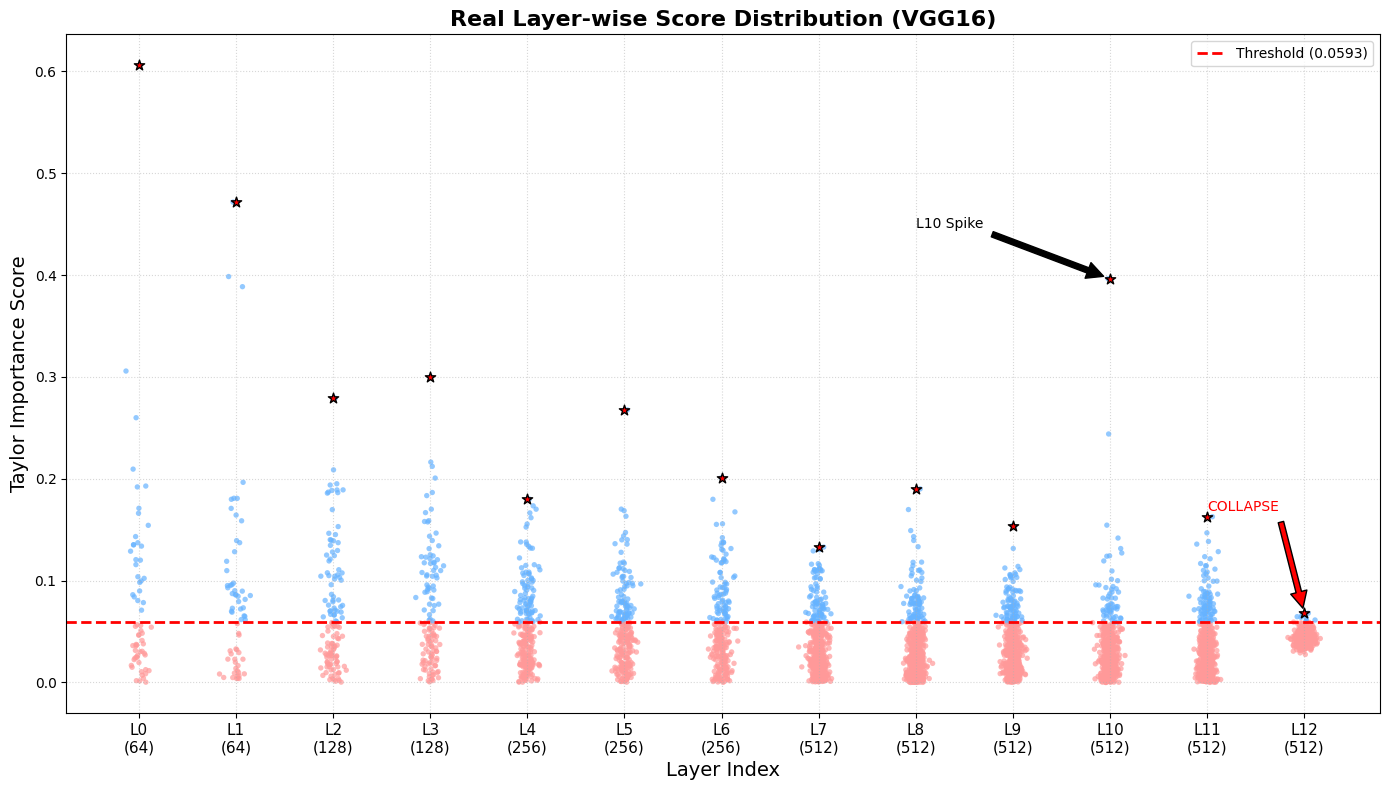

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 1. GỌI HÀM 
try:
    layer_data = ga_pruner.build_ranking_tables(old_pruner) 
except NameError:
    layer_data = ga_pruner.build_ranking_tables(pruner_helper)

# Kiểm tra dữ liệu
if not layer_data:
    print("❌ Layer Data is empty! Cannot plot.")
else:
    # 2. XỬ LÝ DỮ LIỆU
    all_scores_flat = [] 
    plot_data = []       

    for item in layer_data:
        scores = item['scores']
        all_scores_flat.extend(scores)
        plot_data.append(scores)

    all_scores_flat = np.array(all_scores_flat)

    # Tính Global Threshold
    global_threshold = np.percentile(all_scores_flat, 80)
    print(f"🔥 Calculated Global Threshold (80%): {global_threshold:.6f}")

    # 3. VẼ BIỂU ĐỒ SCATTER
    plt.figure(figsize=(14, 8))
    
    layer_indices = range(len(plot_data))
    layer_labels = [f"L{item['layer_idx']}\n({item['num_filters']})" for item in layer_data]

    for i, scores in enumerate(plot_data):
        x_jitter = np.random.normal(i, 0.05, size=len(scores))
        colors = ['#ff9999' if s < global_threshold else '#66b3ff' for s in scores]
        plt.scatter(x_jitter, scores, s=15, c=colors, alpha=0.7, edgecolors='none')
        plt.scatter(i, np.max(scores), s=60, c='red', marker='*', edgecolors='black', zorder=10)

    plt.axhline(y=global_threshold, color='red', linestyle='--', linewidth=2, label=f'Threshold ({global_threshold:.4f})')

    plt.title('Real Layer-wise Score Distribution (VGG16)', fontsize=16, fontweight='bold')
    plt.ylabel('Taylor Importance Score', fontsize=14)
    plt.xlabel('Layer Index', fontsize=14)
    plt.xticks(layer_indices, layer_labels, fontsize=11)
    
    # Annotations L10 & L12
    if len(plot_data) > 10:
        l10_max = np.max(plot_data[10])
        plt.annotate('L10 Spike', xy=(10, l10_max), xytext=(8, l10_max+0.05), arrowprops=dict(facecolor='black', shrink=0.05))
    if len(plot_data) > 12:
        l12_max = np.max(plot_data[12])
        plt.annotate('COLLAPSE', xy=(12, l12_max), xytext=(11, l12_max+0.1), arrowprops=dict(facecolor='red', shrink=0.05), color='red')

    plt.grid(True, linestyle=':', alpha=0.5)
    plt.legend()
    plt.tight_layout()
    plt.savefig('real_score_distribution.png', dpi=300)
    plt.show()

### 5.2. Starting GA Evolution


🚀 Starting GA Evolution... Target MACs <= 20.0%
Gen 1/30 | Fit: -0.8587 | MACs: 0.09G | Params: 5.76M
Gen 2/30 | Fit: -0.6035 | MACs: 0.09G | Params: 3.93M
Gen 3/30 | Fit: -0.5348 | MACs: 0.09G | Params: 5.30M
Gen 4/30 | Fit: -0.1144 | MACs: 0.07G | Params: 3.23M
Gen 5/30 | Fit: 0.0982 | MACs: 0.06G | Params: 3.67M
Gen 6/30 | Fit: 0.0982 | MACs: 0.06G | Params: 3.67M
Gen 7/30 | Fit: 0.1600 | MACs: 0.07G | Params: 2.93M
Gen 8/30 | Fit: 0.1600 | MACs: 0.07G | Params: 2.93M
Gen 9/30 | Fit: 0.1600 | MACs: 0.07G | Params: 2.93M
Gen 10/30 | Fit: 0.2222 | MACs: 0.06G | Params: 2.84M
Gen 11/30 | Fit: 0.2237 | MACs: 0.06G | Params: 2.85M
Gen 12/30 | Fit: 0.2673 | MACs: 0.07G | Params: 3.89M
Gen 13/30 | Fit: 0.3449 | MACs: 0.06G | Params: 2.77M
Gen 14/30 | Fit: 0.3562 | MACs: 0.07G | Params: 3.85M
Gen 15/30 | Fit: 0.3614 | MACs: 0.07G | Params: 3.92M
Gen 16/30 | Fit: 0.3619 | MACs: 0.06G | Params: 4.23M
Gen 17/30 | Fit: 0.3619 | MACs: 0.06G | Params: 4.23M
Gen 18/30 | Fit: 0.3619 | MACs: 0.06G 

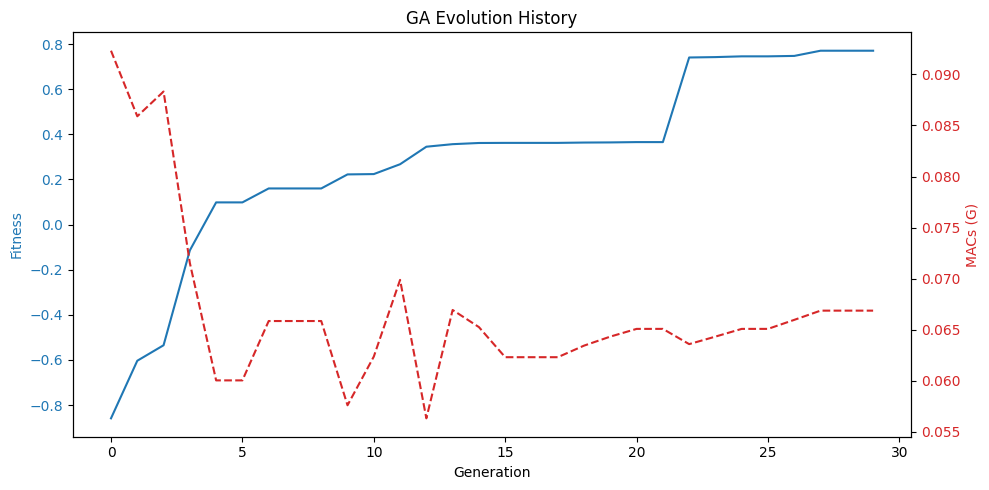

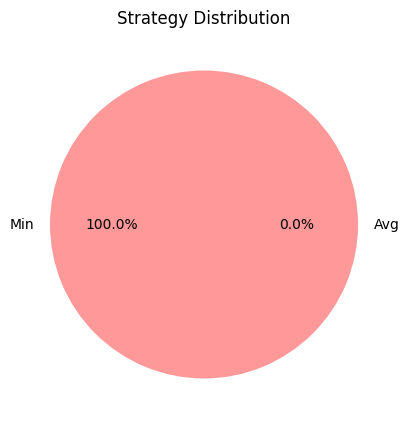

In [9]:
SEED = 2001
np.random.seed(SEED)
torch.manual_seed(SEED)

# Chạy GA: Ví dụ muốn giảm còn 30% MACs (giảm 70%)
# target_macs_ratio = 0.3 nghĩa là giữ lại 30% MACs gốc
best_chrom = ga_pruner.evolve(pop_size=50, n_generations=30, target_macs_ratio=0.2)

# Vẽ biểu đồ báo cáo
ga_pruner.plot_results(best_chrom)

### 5.3. Physical pruning GA Execution

In [10]:
# ==============================================================================
# CELL 3: PHYSICAL PRUNING (GA-CONSISTENT EXECUTION)
# ==============================================================================
import copy
import numpy as np
import torch
import torch.nn as nn
import torch_pruning as tp

print("\n✂️ Applying GA-consistent Physical Pruning...")

# ------------------------------------------------------------------
# 0. Chuẩn bị: snapshot model gốc & ranking GLOBAL
# ------------------------------------------------------------------
base_model = copy.deepcopy(model).cpu()
base_model.eval()

# LẤY GLOBAL RANKING (đúng với GA fitness)
# Không bao giờ dùng ranking sau prune
global_layer_stats = ga_pruner.layer_stats        # chứa raw + norm
global_ranking_tables = ga_pruner.ranking_tables  # min + avg (global ref)

# ------------------------------------------------------------------
# 1. Decode pruning plan từ GA
# ------------------------------------------------------------------
pruning_plan = ga_pruner.apply_best_pruning(best_chrom)

# ------------------------------------------------------------------
# 2. Khởi tạo model mới để prune (NO CASCADE)
# ------------------------------------------------------------------
pruned_model = copy.deepcopy(base_model)

# Helper: map GA-layer-idx → real Conv2d idx trong model.features
def map_ga_to_model_conv(model, ga_idx):
    conv_count = 0
    for idx, m in enumerate(model.features):
        if isinstance(m, nn.Conv2d):
            if conv_count == ga_idx:
                return idx
            conv_count += 1
    return -1

# ------------------------------------------------------------------
# 3. Prune từng layer ĐỘC LẬP – đúng GA assumption
# ------------------------------------------------------------------
for item in pruning_plan:
    layer_idx = item['layer_idx']
    n_keep = item['n_keep']
    strategy = item['strategy']

    # Lấy ranking GLOBAL (model gốc)
    raw_scores = global_layer_stats[layer_idx]['raw']
    total_filters = len(raw_scores)

    n_prune = total_filters - n_keep
    if n_prune <= 0:
        continue

    # Sort index theo Taylor score (weak → strong)
    sorted_idx = np.argsort(raw_scores)

    # -------------------------------
    # STRATEGY HANDLING (PAPER-LEVEL)
    # -------------------------------
    if strategy == 'min':
        # Cắt filter yếu nhất của layer
        indices_to_prune = sorted_idx[:n_prune]

    elif strategy == 'avg':
        # GLOBAL MEDIAN STRATEGY
        # Giữ band trung vị của GLOBAL distribution
        global_ref = global_ranking_tables['avg'][layer_idx]

        g_low = np.percentile(global_ref, 25)
        g_high = np.percentile(global_ref, 75)

        # Prune filter quá yếu hoặc quá mạnh
        indices_to_prune = np.where(
            (raw_scores < g_low) | (raw_scores > g_high)
        )[0]

        # Safety: nếu prune quá tay → fallback sang min
        if len(indices_to_prune) > n_prune:
            indices_to_prune = indices_to_prune[:n_prune]

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # Reverse sort để prune an toàn
    indices_to_prune = sorted(indices_to_prune, reverse=True)

    # Map sang layer thực trong model
    real_layer_idx = map_ga_to_model_conv(pruned_model, layer_idx)
    assert real_layer_idx >= 0, f"Cannot map GA layer {layer_idx}"

    print(
        f"   GA-Layer {layer_idx} → Model-Layer {real_layer_idx}: "
        f"Pruning {len(indices_to_prune)}/{total_filters} [{strategy}]"
    )

    # -------------------------------
    # THỰC HIỆN PRUNING
    # -------------------------------
    for fidx in indices_to_prune:
        prune_vgg16_conv_layer_BN(
            pruned_model,
            real_layer_idx,
            fidx,
            use_cuda=False
        )

# ------------------------------------------------------------------
# 4. Chuyển model về device & kiểm tra
# ------------------------------------------------------------------
pruned_model = pruned_model.to(config.device)
pruned_model.eval()

final_macs, final_params = tp.utils.count_ops_and_params(
    pruned_model,
    input_size
)

print("\n✅ Physical Pruning Finished.")
print(
    f"📉 Final Model Stats: "
    f"MACs={final_macs/1e9:.3f}G | Params={final_params/1e6:.3f}M"
)

# ------------------------------------------------------------------
# 5. Log Expected vs Actual (RẤT QUAN TRỌNG CHO PAPER)
# ------------------------------------------------------------------
expected_macs, expected_params = ga_pruner._estimate_metrics(
    ga_pruner._decode_chromosome(best_chrom)[0]
)

print(
    f"🧮 Expected MACs (GA): {expected_macs/1e9:.3f}G | "
    f"Actual MACs: {final_macs/1e9:.3f}G"
)

# Snapshot chuẩn sau pruning (KHÔNG được mutate)
final_pruned_model = copy.deepcopy(pruned_model)


✂️ Applying GA-consistent Physical Pruning...

✂️ Pruning Plan:
Layer 0: Keep 24 (min)
Layer 1: Keep 32 (min)
Layer 2: Keep 48 (min)
Layer 3: Keep 56 (min)
Layer 4: Keep 96 (min)
Layer 5: Keep 104 (min)
Layer 6: Keep 96 (min)
Layer 7: Keep 320 (min)
Layer 8: Keep 200 (min)
Layer 9: Keep 264 (min)
Layer 10: Keep 312 (min)
Layer 11: Keep 448 (min)
Layer 12: Keep 344 (min)
   GA-Layer 0 → Model-Layer 0: Pruning 40/64 [min]
   GA-Layer 1 → Model-Layer 3: Pruning 32/64 [min]
   GA-Layer 2 → Model-Layer 7: Pruning 80/128 [min]
   GA-Layer 3 → Model-Layer 10: Pruning 72/128 [min]
   GA-Layer 4 → Model-Layer 14: Pruning 160/256 [min]
   GA-Layer 5 → Model-Layer 17: Pruning 152/256 [min]
   GA-Layer 6 → Model-Layer 20: Pruning 160/256 [min]
   GA-Layer 7 → Model-Layer 24: Pruning 192/512 [min]
   GA-Layer 8 → Model-Layer 27: Pruning 312/512 [min]
   GA-Layer 9 → Model-Layer 30: Pruning 248/512 [min]
   GA-Layer 10 → Model-Layer 34: Pruning 200/512 [min]
   GA-Layer 11 → Model-Layer 37: Pruning

### 5.4. Finetune

#### 5.4.1. Normal

In [10]:
# ==============================================================================
# CELL 3A: FINE-TUNING NORMAL (INDEPENDENT)
# ==============================================================================

print("\n🚀 Fine-tuning NORMAL (from pruned snapshot)")

device = config.device

# ⚠️ QUAN TRỌNG: deepcopy
normal_ft_model = copy.deepcopy(final_pruned_model).to(device)
normal_ft_model.train()

train_loader = old_pruner.train_loader
test_loader  = old_pruner.test_loader

optimizer = optim.SGD(
    normal_ft_model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=150
)

criterion = nn.CrossEntropyLoss()

best_acc_normal = 0.0

for epoch in range(150):
    normal_ft_model.train()
    correct, total, train_loss = 0, 0, 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = normal_ft_model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(normal_ft_model.parameters(), 5.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    scheduler.step()

    train_acc = 100. * correct / total

    normal_ft_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = normal_ft_model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total

    print(f"[NORMAL] Epoch {epoch+1:03d} | Train {train_acc:.2f}% | Val {val_acc:.2f}%")

    if val_acc > best_acc_normal:
        best_acc_normal = val_acc
        torch.save({
            'model': normal_ft_model.state_dict(),
            'acc': best_acc_normal
        }, "./checkpoint/pruned_finetuned_normal.pth")

print(f"✅ NORMAL FT Best Acc = {best_acc_normal:.2f}%")


🚀 Fine-tuning NORMAL (from pruned snapshot)


[NORMAL] Epoch 001 | Train 69.27% | Val 80.79%
[NORMAL] Epoch 002 | Train 84.58% | Val 83.15%
[NORMAL] Epoch 003 | Train 87.81% | Val 85.22%
[NORMAL] Epoch 004 | Train 89.69% | Val 86.65%
[NORMAL] Epoch 005 | Train 90.93% | Val 87.50%
[NORMAL] Epoch 006 | Train 91.59% | Val 87.28%
[NORMAL] Epoch 007 | Train 92.51% | Val 88.07%
[NORMAL] Epoch 008 | Train 93.03% | Val 88.30%


KeyboardInterrupt: 

#### 5.4.2. KD

In [8]:
# ==============================================================================
# CELL 4: FINE-TUNING VỚI KNOWLEDGE DISTILLATION (KD)
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import os

# --- 1. Cấu hình KD ---
# Hyper-parameters
KD_EPOCHS = 150           # Số epoch train lại (nên train kỹ)
KD_LR = 0.01              # Learning rate (thấp hơn train from scratch)
KD_TEMP = 4.0             # Temperature (độ mềm của xác suất)
KD_ALPHA = 0.9            # 90% học từ Teacher, 10% học từ Label thật
TEACHER_PATH = "./checkpoint/vgg16_cifar10_baseline.pth" # Đường dẫn model gốc
# TEACHER_PATH = "./checkpoint/vgg16_cifar100_baseline.pth" # Đường dẫn model gốc

# Hàm Loss Distillation
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.9):
        super(DistillationLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
        
    def forward(self, student_logits, teacher_logits, labels):
        # Loss 1: Hard Loss (Cross Entropy với nhãn thật)
        hard_loss = F.cross_entropy(student_logits, labels)
        
        # Loss 2: Soft Loss (KL Divergence với Teacher)
        soft_loss = F.kl_div(
            F.log_softmax(student_logits / self.T, dim=1),
            F.softmax(teacher_logits / self.T, dim=1),
            reduction='batchmean'
        ) * (self.T * self.T)
        
        return self.alpha * soft_loss + (1. - self.alpha) * hard_loss

# --- 2. Chuẩn bị Teacher & Student ---
print("🚀 Đang khởi tạo Knowledge Distillation...")

# A. Load Teacher (Mô hình gốc chưa cắt)
if not os.path.exists(TEACHER_PATH):
    raise FileNotFoundError(f"❌ Không tìm thấy file checkpoint Teacher tại: {TEACHER_PATH}")

teacher_model = ModifiedVGG16Model(config).to(config.device)
ckpt_t = torch.load(TEACHER_PATH, map_location=config.device)
teacher_model.load_state_dict(ckpt_t['model'])
teacher_model.eval() # Teacher chỉ dạy, không học
for param in teacher_model.parameters():
    param.requires_grad = False # Đóng băng Teacher

print(f"✅ Teacher loaded (Acc: {ckpt_t.get('acc', 'N/A')}%)")

# B. Student (Là model đang nằm trong bộ nhớ sau khi chạy Cell 3)
# Lưu ý: Biến 'model' ở đây là model đã bị cắt tỉa vật lý ở cell trước
student_model = copy.deepcopy(final_pruned_model).to(config.device) 
student_model.train()
print("✅ Student (Pruned Model) ready.")

# --- 3. Thiết lập Training ---
criterion_kd = DistillationLoss(temperature=KD_TEMP, alpha=KD_ALPHA)
optimizer_kd = optim.SGD(student_model.parameters(), lr=KD_LR, momentum=0.9, weight_decay=5e-4)
scheduler_kd = optim.lr_scheduler.CosineAnnealingLR(optimizer_kd, T_max=KD_EPOCHS)

# Tận dụng Data Loader có sẵn từ old_pruner
train_loader = old_pruner.train_loader
test_loader = old_pruner.test_loader

# --- 4. Vòng lặp Training KD ---
best_acc_kd = 0
save_name_kd = 'pruned_student_distilled.pth'
# save_name_kd = 'pruned_student_distilled_100.pth'

print(f"\n🔥 Bắt đầu Training KD trong {KD_EPOCHS} epochs...")

for epoch in range(KD_EPOCHS):
    student_model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(config.device), targets.to(config.device)
        
        optimizer_kd.zero_grad()
        
        # Forward Teacher (No grad)
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)
            
        # Forward Student
        student_logits = student_model(inputs)
        
        # Tính Loss tổng hợp
        loss = criterion_kd(student_logits, teacher_logits, targets)
        
        loss.backward()
        # Kẹp gradient để tránh lỗi exploding (quan trọng cho mạng đã cắt)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=5.0)
        optimizer_kd.step()
        
        train_loss += loss.item()
        _, predicted = student_logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Update LR
    scheduler_kd.step()
    
    # --- Test Student ---
    student_model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = student_model(inputs)
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()
            
    acc_test = 100. * test_correct / test_total
    
    # Log gọn gàng
    print(f"Epoch {epoch+1}/{KD_EPOCHS} | Loss: {train_loss/(batch_idx+1):.3f} | Train Acc: {100.*correct/total:.2f}% | Val Acc: {acc_test:.2f}%")
    
    # Lưu Best Checkpoint
    if acc_test > best_acc_kd:
        best_acc_kd = acc_test
        print(f"   ---> 💾 Saving Best Student (Acc: {best_acc_kd:.2f}%)")
        torch.save({
            'model': student_model.state_dict(),
            'acc': best_acc_kd,
            'epoch': epoch
        }, f'./checkpoint/{save_name_kd}')

print(f"\n🎉 HOÀN TẤT DISTILLATION! Kết quả tốt nhất: {best_acc_kd:.2f}%")
print(f"File saved at: ./checkpoint/{save_name_kd}")

🚀 Đang khởi tạo Knowledge Distillation...
✅ Teacher loaded (Acc: 93.62%)
✅ Student (Pruned Model) ready.

🔥 Bắt đầu Training KD trong 150 epochs...
Epoch 1/150 | Loss: 4.844 | Train Acc: 65.64% | Val Acc: 67.99%
   ---> 💾 Saving Best Student (Acc: 67.99%)
Epoch 2/150 | Loss: 3.306 | Train Acc: 76.75% | Val Acc: 75.12%
   ---> 💾 Saving Best Student (Acc: 75.12%)
Epoch 3/150 | Loss: 2.865 | Train Acc: 79.85% | Val Acc: 77.75%
   ---> 💾 Saving Best Student (Acc: 77.75%)
Epoch 4/150 | Loss: 2.567 | Train Acc: 82.00% | Val Acc: 82.54%
   ---> 💾 Saving Best Student (Acc: 82.54%)
Epoch 5/150 | Loss: 2.367 | Train Acc: 83.64% | Val Acc: 79.46%
Epoch 6/150 | Loss: 2.200 | Train Acc: 84.64% | Val Acc: 81.90%
Epoch 7/150 | Loss: 2.061 | Train Acc: 85.59% | Val Acc: 80.92%
Epoch 8/150 | Loss: 1.947 | Train Acc: 86.44% | Val Acc: 78.85%
Epoch 9/150 | Loss: 1.868 | Train Acc: 87.11% | Val Acc: 83.69%
   ---> 💾 Saving Best Student (Acc: 83.69%)
Epoch 10/150 | Loss: 1.783 | Train Acc: 87.57% | Val Acc

## 6. NSGAPruner

In [11]:
#==============================================================================
#CELL 1: NSGA-II PRUNER (CORE)
#==============================================================================
import random
import numpy as np
from dataclasses import dataclass

@dataclass
class NSGASolution:
    chrom: list
    acc: float = None
    macs: float = None
    params: float = None
    rank: int = None
    crowding: float = 0.0


class NSGAPruner:
    def __init__(self, base_model, ga_pruner,
                 pop_size=40, generations=30,
                 min_ratio=0.1):
        self.base_model = base_model
        self.ga_pruner = ga_pruner
        self.pop_size = pop_size
        self.generations = generations
        self.min_ratio = min_ratio

        self.n_layers = len(ga_pruner.conv_layers)
        self.population = []

    # --------------------------------------------------
    # Chromosome: [ratio_0, strategy_0, ..., ratio_L, strategy_L]
    # --------------------------------------------------
    def random_chrom(self):
        chrom = []
        for _ in range(self.n_layers):
            chrom.append(random.uniform(self.min_ratio, 1.0))  # ratio
            chrom.append(random.random())                       # strategy gene
        return chrom

    def init_population(self):
        self.population = [
            NSGASolution(self.random_chrom())
            for _ in range(self.pop_size)
        ]

    # --------------------------------------------------
    # Fitness evaluation (PROXY – GA level)
    # --------------------------------------------------
    def evaluate(self, sol):
        channels, strategies = self.ga_pruner._decode_chromosome(sol.chrom)

        macs, params = self.ga_pruner._estimate_metrics(channels)
        proxy_acc = self.ga_pruner.proxy_capacity_score(channels, strategies)

        sol.acc = proxy_acc
        sol.macs = macs
        sol.params = params

    # --------------------------------------------------
    # NSGA-II: Non-dominated sorting
    # --------------------------------------------------
    def dominates(self, a, b):
        return (
            (a.acc >= b.acc and a.macs <= b.macs and a.params <= b.params) and
            (a.acc > b.acc or a.macs < b.macs or a.params < b.params)
        )

    def fast_nondominated_sort(self):
        fronts = [[]]
        for p in self.population:
            p.dom_count = 0
            p.dom_set = []
            for q in self.population:
                if self.dominates(p, q):
                    p.dom_set.append(q)
                elif self.dominates(q, p):
                    p.dom_count += 1
            if p.dom_count == 0:
                p.rank = 0
                fronts[0].append(p)

        i = 0
        while fronts[i]:
            next_front = []
            for p in fronts[i]:
                for q in p.dom_set:
                    q.dom_count -= 1
                    if q.dom_count == 0:
                        q.rank = i + 1
                        next_front.append(q)
            i += 1
            fronts.append(next_front)
        return fronts[:-1]

    def crowding_distance(self, front):
        if not front:
            return
        for s in front:
            s.crowding = 0

        for key in ['acc', 'macs', 'params']:
            front.sort(key=lambda x: getattr(x, key))
            front[0].crowding = front[-1].crowding = float('inf')
            min_v = getattr(front[0], key)
            max_v = getattr(front[-1], key)
            if max_v == min_v:
                continue
            for i in range(1, len(front)-1):
                prev_v = getattr(front[i-1], key)
                next_v = getattr(front[i+1], key)
                front[i].crowding += (next_v - prev_v) / (max_v - min_v)

    # --------------------------------------------------
    def select_next_population(self, fronts):
        new_pop = []
        for f in fronts:
            self.crowding_distance(f)
            if len(new_pop) + len(f) <= self.pop_size:
                new_pop.extend(f)
            else:
                f.sort(key=lambda x: -x.crowding)
                new_pop.extend(f[:self.pop_size - len(new_pop)])
                break
        self.population = new_pop

    # --------------------------------------------------
    def crossover(self, p1, p2):
        cut = random.randint(1, len(p1.chrom)-2)
        c1 = p1.chrom[:cut] + p2.chrom[cut:]
        c2 = p2.chrom[:cut] + p1.chrom[cut:]
        return NSGASolution(c1), NSGASolution(c2)

    def mutate(self, sol, prob=0.1):
        for i in range(len(sol.chrom)):
            if random.random() < prob:
                if i % 2 == 0:
                    sol.chrom[i] = random.uniform(self.min_ratio, 1.0)
                else:
                    sol.chrom[i] = random.random()

    # --------------------------------------------------
    def run(self):
        self.init_population()

        for g in range(self.generations):
            for s in self.population:
                self.evaluate(s)

            fronts = self.fast_nondominated_sort()
            self.select_next_population(fronts)

            offspring = []
            while len(offspring) < self.pop_size:
                p1, p2 = random.sample(self.population, 2)
                c1, c2 = self.crossover(p1, p2)
                self.mutate(c1)
                self.mutate(c2)
                offspring.extend([c1, c2])

            self.population = offspring[:self.pop_size]

        # Final eval
        for s in self.population:
            self.evaluate(s)

    def get_pareto_front(self):
        fronts = self.fast_nondominated_sort()
        return fronts[0]

### 6.1. NSGA executtion

In [12]:
SEED = 2026
np.random.seed(SEED)
torch.manual_seed(SEED)

# 1. Cấu hình & Load Model
config = Config()
config.dataset_class = 'CIFAR10'
# config.dataset_class = 'CIFAR100'
config.classifier_type = 'B' # Hoặc loại bạn đã train
config.device = 'cuda' if torch.cuda.is_available() else 'cpu'

# Tạo model và load weight cũ
model = ModifiedVGG16Model(config).to(config.device)
checkpoint = torch.load("./checkpoint/vgg16_cifar10_baseline.pth", map_location=config.device) # Đường dẫn file ckpt của bạn
model.load_state_dict(checkpoint['model'])
print(f"✅ Loaded model from epoch {checkpoint['epoch']} with Acc: {checkpoint['acc']}%")

# 2. Khởi tạo Helper cũ (để lấy dữ liệu train tính rank)
# Helper này chịu trách nhiệm tính Taylor Score
old_pruner = VGG16Pruner(config, model, save_name='10_ga_optimise_ckpt.pth') 

# 3. Khởi tạo GA Pruner (Code mới)
input_size = torch.randn(1, 3, 32, 32).to(config.device)
ga_pruner = GAPruner(model, config, input_size)

ga_pruner.strategy_mode = 'layer_wise'

# 4. Xây dựng bảng tra cứu (Bước này chạy ~1 epoch để tính rank, mất khoảng 1-2 phút)
ga_pruner.build_ranking_tables(old_pruner, old_pruner.train_loader)

nsga = NSGAPruner(
    base_model=model,
    ga_pruner=ga_pruner,
    pop_size=50,
    generations=30
)

nsga.run()
pareto = nsga.get_pareto_front()

print(f"✅ Pareto size: {len(pareto)}")
for s in pareto:
    print(
        f"ProxyAcc={s.acc:.4f} | "
        f"MACs={s.macs/1e9:.3f}G | "
        f"Params={s.params/1e6:.2f}M"
    )

✅ Loaded model from epoch 183 with Acc: 93.62%
Base MACs: 0.3334G | Base Params: 33.6467M
Analyzed 13 Conv layers for fast estimation.

Step 1: Building Ranking Tables (Pre-computation)...
   Running ranking epoch (accumulating gradients)...

📊 --- SMART MATCHING LAYERS ---
   Raw ranks key type: <class 'int'>
   Layer 12: max=0.0732, mean=0.0438
   Layer 11: max=0.1623, mean=0.0343
   Layer 2: max=0.3049, mean=0.0709
   Layer 1: max=0.3527, mean=0.0888
   Layer 0: max=0.4344, mean=0.0783
✅ Successfully built ranking tables for 13 layers.
✅ Pareto size: 27
ProxyAcc=0.7825 | MACs=0.085G | Params=5.03M
ProxyAcc=0.8574 | MACs=0.101G | Params=5.27M
ProxyAcc=0.8727 | MACs=0.114G | Params=4.91M
ProxyAcc=0.7957 | MACs=0.101G | Params=2.94M
ProxyAcc=0.9152 | MACs=0.138G | Params=8.05M
ProxyAcc=0.6660 | MACs=0.062G | Params=2.07M
ProxyAcc=0.7907 | MACs=0.088G | Params=3.86M
ProxyAcc=0.8226 | MACs=0.106G | Params=3.43M
ProxyAcc=0.7338 | MACs=0.084G | Params=2.23M
ProxyAcc=0.7390 | MACs=0.071G | 

#### Plot Pareto Front + Find Knee Point

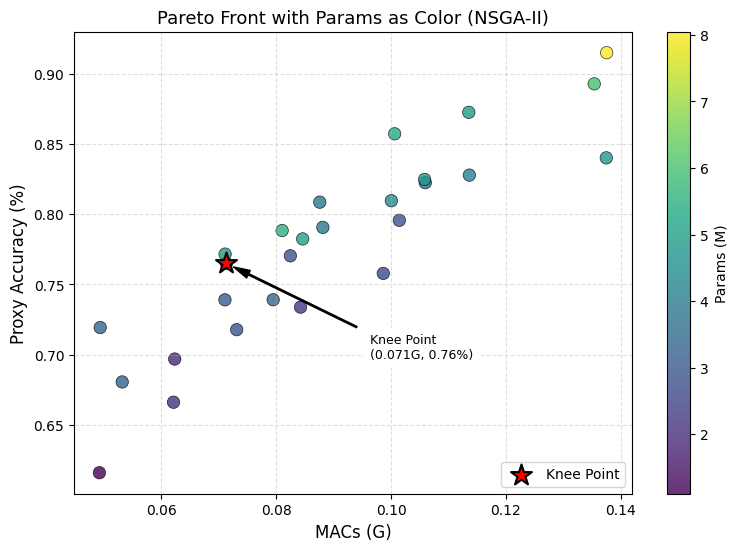

🏁 Knee: MACs=0.071G | Params=3.30M | Acc≈0.76%


In [13]:
import matplotlib.pyplot as plt
import numpy as np

macs = np.array([s.macs / 1e9 for s in pareto])
accs = np.array([s.acc for s in pareto])
params = np.array([s.params / 1e6 for s in pareto])

# Knee point calculation (3 objectives)
m_norm = (macs - macs.min()) / (macs.max() - macs.min())
a_norm = (accs.max() - accs) / (accs.max() - accs.min())
p_norm = (params - params.min()) / (params.max() - params.min())
dist = np.sqrt(m_norm**2 + a_norm**2 + p_norm**2)
# dist = np.sqrt(m_norm**2 + a_norm**2)
knee_idx = np.argmin(dist)
knee_sol = pareto[knee_idx]

# ==========================================
# OPTION B: 2D Plot với Params as Color
# ==========================================
plt.figure(figsize=(9, 6))

# Scatter với color = Params
scatter = plt.scatter(macs, accs, c=params, cmap='viridis', s=80, 
                      edgecolors='black', linewidth=0.5, alpha=0.8)
plt.colorbar(scatter, label='Params (M)')

# Highlight Knee Point
plt.scatter(knee_sol.macs/1e9, knee_sol.acc, 
            c='red', s=250, marker='*', 
            edgecolors='black', linewidth=1.5, 
            zorder=10, label='Knee Point')

# Annotation - mũi tên từ góc dưới bên phải chỉ lên 45 độ
plt.annotate(f'Knee Point\n({knee_sol.macs/1e9:.3f}G, {knee_sol.acc:.2f}%)',
             xy=(knee_sol.macs/1e9, knee_sol.acc),                    # Điểm Knee
             xytext=(knee_sol.macs/1e9 + 0.025, knee_sol.acc - 0.05), # Text ở dưới-phải
             arrowprops=dict(facecolor='black', shrink=0.05, width=1, headwidth=6),
             fontsize=9, backgroundcolor='white',
             ha='left', va='top')  # Căn text trái-trên

plt.xlabel("MACs (G)", fontsize=12)
plt.ylabel("Proxy Accuracy (%)", fontsize=12)
plt.title("Pareto Front with Params as Color (NSGA-II)", fontsize=13)
plt.legend(loc='lower right')
plt.grid(True, linestyle='--', alpha=0.4)

# Save for paper
plt.savefig('pareto_front_3obj.png', dpi=300, bbox_inches='tight')
plt.show()

print(
    f"🏁 Knee: MACs={knee_sol.macs/1e9:.3f}G | "
    f"Params={knee_sol.params/1e6:.2f}M | "
    f"Acc≈{knee_sol.acc:.2f}%"
)

### 6.2. Physical pruning NSGA

In [14]:
# ==============================================================================
# CELL 3: PHYSICAL PRUNING (GA-CONSISTENT EXECUTION)
# ==============================================================================
import copy
import numpy as np
import torch
import torch.nn as nn
import torch_pruning as tp

print("\n✂️ Applying GA-consistent Physical Pruning...")

# ------------------------------------------------------------------
# 0. Chuẩn bị: snapshot model gốc & ranking GLOBAL
# ------------------------------------------------------------------
base_model = copy.deepcopy(model).cpu()
base_model.eval()
best_chrom = knee_sol.chrom

# LẤY GLOBAL RANKING (đúng với GA fitness)
# Không bao giờ dùng ranking sau prune
global_layer_stats = ga_pruner.layer_stats        # chứa raw + norm
global_ranking_tables = ga_pruner.ranking_tables  # min + avg (global ref)

# ------------------------------------------------------------------
# 1. Decode pruning plan từ GA
# ------------------------------------------------------------------
pruning_plan = ga_pruner.apply_best_pruning(best_chrom)

# ------------------------------------------------------------------
# 2. Khởi tạo model mới để prune (NO CASCADE)
# ------------------------------------------------------------------
pruned_model = copy.deepcopy(base_model)

# Helper: map GA-layer-idx → real Conv2d idx trong model.features
def map_ga_to_model_conv(model, ga_idx):
    conv_count = 0
    for idx, m in enumerate(model.features):
        if isinstance(m, nn.Conv2d):
            if conv_count == ga_idx:
                return idx
            conv_count += 1
    return -1

# ------------------------------------------------------------------
# 3. Prune từng layer ĐỘC LẬP – đúng GA assumption
# ------------------------------------------------------------------
for item in pruning_plan:
    layer_idx = item['layer_idx']
    n_keep = item['n_keep']
    strategy = item['strategy']

    # Lấy ranking GLOBAL (model gốc)
    raw_scores = global_layer_stats[layer_idx]['raw']
    total_filters = len(raw_scores)

    n_prune = total_filters - n_keep
    if n_prune <= 0:
        continue

    # Sort index theo Taylor score (weak → strong)
    sorted_idx = np.argsort(raw_scores)

    # -------------------------------
    # STRATEGY HANDLING (PAPER-LEVEL)
    # -------------------------------
    if strategy == 'min':
        # Cắt filter yếu nhất của layer
        indices_to_prune = sorted_idx[:n_prune]

    elif strategy == 'avg':
        # GLOBAL MEDIAN STRATEGY
        # Giữ band trung vị của GLOBAL distribution
        global_ref = global_ranking_tables['avg'][layer_idx]

        g_low = np.percentile(global_ref, 25)
        g_high = np.percentile(global_ref, 75)

        # Prune filter quá yếu hoặc quá mạnh
        indices_to_prune = np.where(
            (raw_scores < g_low) | (raw_scores > g_high)
        )[0]

        # Safety: nếu prune quá tay → fallback sang min
        if len(indices_to_prune) > n_prune:
            indices_to_prune = indices_to_prune[:n_prune]

    else:
        raise ValueError(f"Unknown strategy: {strategy}")

    # Reverse sort để prune an toàn
    indices_to_prune = sorted(indices_to_prune, reverse=True)

    # Map sang layer thực trong model
    real_layer_idx = map_ga_to_model_conv(pruned_model, layer_idx)
    assert real_layer_idx >= 0, f"Cannot map GA layer {layer_idx}"

    print(
        f"   GA-Layer {layer_idx} → Model-Layer {real_layer_idx}: "
        f"Pruning {len(indices_to_prune)}/{total_filters} [{strategy}]"
    )

    # -------------------------------
    # THỰC HIỆN PRUNING
    # -------------------------------
    for fidx in indices_to_prune:
        prune_vgg16_conv_layer_BN(
            pruned_model,
            real_layer_idx,
            fidx,
            use_cuda=False
        )

# ------------------------------------------------------------------
# 4. Chuyển model về device & kiểm tra
# ------------------------------------------------------------------
pruned_model = pruned_model.to(config.device)
pruned_model.eval()

final_macs, final_params = tp.utils.count_ops_and_params(
    pruned_model,
    input_size
)

print("\n✅ Physical Pruning Finished.")
print(
    f"📉 Final Model Stats: "
    f"MACs={final_macs/1e9:.3f}G | Params={final_params/1e6:.3f}M"
)

# ------------------------------------------------------------------
# 5. Log Expected vs Actual (RẤT QUAN TRỌNG CHO PAPER)
# ------------------------------------------------------------------
expected_macs, expected_params = ga_pruner._estimate_metrics(
    ga_pruner._decode_chromosome(best_chrom)[0]
)

print(
    f"🧮 Expected MACs (NSGA-II): {expected_macs/1e9:.3f}G | "
    f"Actual MACs: {final_macs/1e9:.3f}G"
)

# Snapshot chuẩn sau pruning (KHÔNG được mutate)
final_pruned_model = copy.deepcopy(pruned_model)


✂️ Applying GA-consistent Physical Pruning...

✂️ Pruning Plan:
Layer 0: Keep 32 (min)
Layer 1: Keep 40 (avg)
Layer 2: Keep 56 (avg)
Layer 3: Keep 64 (min)
Layer 4: Keep 40 (avg)
Layer 5: Keep 208 (avg)
Layer 6: Keep 88 (avg)
Layer 7: Keep 272 (min)
Layer 8: Keep 264 (min)
Layer 9: Keep 216 (min)
Layer 10: Keep 288 (avg)
Layer 11: Keep 168 (min)
Layer 12: Keep 400 (min)
   GA-Layer 0 → Model-Layer 0: Pruning 32/64 [min]
   GA-Layer 1 → Model-Layer 3: Pruning 24/64 [avg]
   GA-Layer 2 → Model-Layer 7: Pruning 72/128 [avg]
   GA-Layer 3 → Model-Layer 10: Pruning 64/128 [min]
   GA-Layer 4 → Model-Layer 14: Pruning 209/256 [avg]
   GA-Layer 5 → Model-Layer 17: Pruning 48/256 [avg]
   GA-Layer 6 → Model-Layer 20: Pruning 168/256 [avg]
   GA-Layer 7 → Model-Layer 24: Pruning 240/512 [min]
   GA-Layer 8 → Model-Layer 27: Pruning 248/512 [min]
   GA-Layer 9 → Model-Layer 30: Pruning 296/512 [min]
   GA-Layer 10 → Model-Layer 34: Pruning 224/512 [avg]
   GA-Layer 11 → Model-Layer 37: Pruning 

### 6.3. Finetune

#### Normal

In [ ]:
# ==============================================================================
# CELL 3A: FINE-TUNIN G NORMAL (INDEPENDENT)
# ==============================================================================

print("\n🚀 Fine-tuning NORMAL (from pruned snapshot)")

device = config.device

# ⚠️ QUAN TRỌNG: deepcopy
normal_ft_model = copy.deepcopy(final_pruned_model).to(device)
normal_ft_model.train()

train_loader = old_pruner.train_loader
test_loader  = old_pruner.test_loader

optimizer = optim.SGD(
    normal_ft_model.parameters(),
    lr=0.001,
    momentum=0.9,
    weight_decay=5e-4
)

scheduler = optim.lr_scheduler.CosineAnnealingLR(
    optimizer, T_max=150
)

criterion = nn.CrossEntropyLoss()

best_acc_normal = 0.0

for epoch in range(150):
    normal_ft_model.train()
    correct, total, train_loss = 0, 0, 0.0

    for inputs, targets in train_loader:
        inputs, targets = inputs.to(device), targets.to(device)

        optimizer.zero_grad()
        outputs = normal_ft_model(inputs)
        loss = criterion(outputs, targets)

        loss.backward()
        torch.nn.utils.clip_grad_norm_(normal_ft_model.parameters(), 5.0)
        optimizer.step()

        train_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

    scheduler.step()

    train_acc = 100. * correct / total

    normal_ft_model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = normal_ft_model(inputs)
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

    val_acc = 100. * correct / total

    print(f"[NORMAL] Epoch {epoch+1:03d} | Train {train_acc:.2f}% | Val {val_acc:.2f}%")

    if val_acc > best_acc_normal:
        best_acc_normal = val_acc
        torch.save({
            'model': normal_ft_model.state_dict(),
            'acc': best_acc_normal
        }, "./checkpoint/pruned_finetuned_normal.pth")

print(f"✅ NORMAL FT Best Acc = {best_acc_normal:.2f}%")


🚀 Fine-tuning NORMAL (from pruned snapshot)
[NORMAL] Epoch 001 | Train 15.15% | Val 30.00%
[NORMAL] Epoch 002 | Train 36.43% | Val 43.07%
[NORMAL] Epoch 003 | Train 47.51% | Val 49.42%
[NORMAL] Epoch 004 | Train 53.93% | Val 52.05%
[NORMAL] Epoch 005 | Train 58.25% | Val 54.80%
[NORMAL] Epoch 006 | Train 62.34% | Val 56.11%
[NORMAL] Epoch 007 | Train 65.27% | Val 57.93%
[NORMAL] Epoch 008 | Train 67.96% | Val 58.98%
[NORMAL] Epoch 009 | Train 69.88% | Val 59.39%
[NORMAL] Epoch 010 | Train 71.72% | Val 60.50%
[NORMAL] Epoch 011 | Train 73.56% | Val 60.70%
[NORMAL] Epoch 012 | Train 74.89% | Val 61.39%
[NORMAL] Epoch 013 | Train 76.31% | Val 61.70%
[NORMAL] Epoch 014 | Train 77.35% | Val 61.99%
[NORMAL] Epoch 015 | Train 78.67% | Val 62.36%
[NORMAL] Epoch 016 | Train 79.60% | Val 62.05%
[NORMAL] Epoch 017 | Train 80.76% | Val 62.48%
[NORMAL] Epoch 018 | Train 81.45% | Val 62.54%
[NORMAL] Epoch 019 | Train 82.40% | Val 62.62%
[NORMAL] Epoch 020 | Train 83.11% | Val 63.25%
[NORMAL] Epoch 

#### KD

In [21]:
# ==============================================================================
# CELL 4: FINE-TUNING VỚI KNOWLEDGE DISTILLATION (KD)
# ==============================================================================
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import copy
import os

# --- 1. Cấu hình KD ---
# Hyper-parameters
KD_EPOCHS = 150           # Số epoch train lại (nên train kỹ)
KD_LR = 0.01              # Learning rate (thấp hơn train from scratch)
KD_TEMP = 4.0             # Temperature (độ mềm của xác suất)
KD_ALPHA = 0.9            # 90% học từ Teacher, 10% học từ Label thật
TEACHER_PATH = "./checkpoint/vgg16_cifar10_baseline.pth" # Đường dẫn model gốc
# TEACHER_PATH = "./checkpoint/vgg16_cifar100_baseline.pth" # Đường dẫn model gốc

# Hàm Loss Distillation
class DistillationLoss(nn.Module):
    def __init__(self, temperature=4.0, alpha=0.9):
        super(DistillationLoss, self).__init__()
        self.T = temperature
        self.alpha = alpha
        
    def forward(self, student_logits, teacher_logits, labels):
        # Loss 1: Hard Loss (Cross Entropy với nhãn thật)
        hard_loss = F.cross_entropy(student_logits, labels)
        
        # Loss 2: Soft Loss (KL Divergence với Teacher)
        soft_loss = F.kl_div(
            F.log_softmax(student_logits / self.T, dim=1),
            F.softmax(teacher_logits / self.T, dim=1),
            reduction='batchmean'
        ) * (self.T * self.T)
        
        return self.alpha * soft_loss + (1. - self.alpha) * hard_loss

# --- 2. Chuẩn bị Teacher & Student ---
print("🚀 Đang khởi tạo Knowledge Distillation...")

# A. Load Teacher (Mô hình gốc chưa cắt)
if not os.path.exists(TEACHER_PATH):
    raise FileNotFoundError(f"❌ Không tìm thấy file checkpoint Teacher tại: {TEACHER_PATH}")

teacher_model = ModifiedVGG16Model(config).to(config.device)
ckpt_t = torch.load(TEACHER_PATH, map_location=config.device)
teacher_model.load_state_dict(ckpt_t['model'])
teacher_model.eval() # Teacher chỉ dạy, không học
for param in teacher_model.parameters():
    param.requires_grad = False # Đóng băng Teacher

print(f"✅ Teacher loaded (Acc: {ckpt_t.get('acc', 'N/A')}%)")

# B. Student (Là model đang nằm trong bộ nhớ sau khi chạy Cell 3)
# Lưu ý: Biến 'model' ở đây là model đã bị cắt tỉa vật lý ở cell trước
student_model = copy.deepcopy(final_pruned_model).to(config.device) 
student_model.train()
print("✅ Student (Pruned Model) ready.")

# --- 3. Thiết lập Training ---
criterion_kd = DistillationLoss(temperature=KD_TEMP, alpha=KD_ALPHA)
optimizer_kd = optim.SGD(student_model.parameters(), lr=KD_LR, momentum=0.9, weight_decay=5e-4)
scheduler_kd = optim.lr_scheduler.CosineAnnealingLR(optimizer_kd, T_max=KD_EPOCHS)

# Tận dụng Data Loader có sẵn từ old_pruner
train_loader = old_pruner.train_loader
test_loader = old_pruner.test_loader

# --- 4. Vòng lặp Training KD ---
best_acc_kd = 0
save_name_kd = 'pruned_student_distilled.pth'
# save_name_kd = 'pruned_student_distilled_100.pth'

print(f"\n🔥 Bắt đầu Training KD trong {KD_EPOCHS} epochs...")

for epoch in range(KD_EPOCHS):
    student_model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for batch_idx, (inputs, targets) in enumerate(train_loader):
        inputs, targets = inputs.to(config.device), targets.to(config.device)
        
        optimizer_kd.zero_grad()
        
        # Forward Teacher (No grad)
        with torch.no_grad():
            teacher_logits = teacher_model(inputs)
            
        # Forward Student
        student_logits = student_model(inputs)
        
        # Tính Loss tổng hợp
        loss = criterion_kd(student_logits, teacher_logits, targets)
        
        loss.backward()
        # Kẹp gradient để tránh lỗi exploding (quan trọng cho mạng đã cắt)
        torch.nn.utils.clip_grad_norm_(student_model.parameters(), max_norm=5.0)
        optimizer_kd.step()
        
        train_loss += loss.item()
        _, predicted = student_logits.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()
        
    # Update LR
    scheduler_kd.step()
    
    # --- Test Student ---
    student_model.eval()
    test_correct = 0
    test_total = 0
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(config.device), targets.to(config.device)
            outputs = student_model(inputs)
            _, predicted = outputs.max(1)
            test_total += targets.size(0)
            test_correct += predicted.eq(targets).sum().item()
            
    acc_test = 100. * test_correct / test_total
    
    # Log gọn gàng
    print(f"Epoch {epoch+1}/{KD_EPOCHS} | Loss: {train_loss/(batch_idx+1):.3f} | Train Acc: {100.*correct/total:.2f}% | Val Acc: {acc_test:.2f}%")
    
    # Lưu Best Checkpoint
    if acc_test > best_acc_kd:
        best_acc_kd = acc_test
        print(f"   ---> 💾 Saving Best Student (Acc: {best_acc_kd:.2f}%)")
        torch.save({
            'model': student_model.state_dict(),
            'acc': best_acc_kd,
            'epoch': epoch
        }, f'./checkpoint/{save_name_kd}')

print(f"\n🎉 HOÀN TẤT DISTILLATION! Kết quả tốt nhất: {best_acc_kd:.2f}%")
print(f"File saved at: ./checkpoint/{save_name_kd}")

🚀 Đang khởi tạo Knowledge Distillation...
✅ Teacher loaded (Acc: 93.62%)
✅ Student (Pruned Model) ready.

🔥 Bắt đầu Training KD trong 150 epochs...
Epoch 1/150 | Loss: 3.631 | Train Acc: 74.80% | Val Acc: 71.63%
   ---> 💾 Saving Best Student (Acc: 71.63%)
Epoch 2/150 | Loss: 2.762 | Train Acc: 80.77% | Val Acc: 75.78%
   ---> 💾 Saving Best Student (Acc: 75.78%)
Epoch 3/150 | Loss: 2.458 | Train Acc: 82.89% | Val Acc: 71.67%
Epoch 4/150 | Loss: 2.170 | Train Acc: 84.93% | Val Acc: 80.99%
   ---> 💾 Saving Best Student (Acc: 80.99%)
Epoch 5/150 | Loss: 2.053 | Train Acc: 85.58% | Val Acc: 81.85%
   ---> 💾 Saving Best Student (Acc: 81.85%)
Epoch 6/150 | Loss: 1.885 | Train Acc: 86.88% | Val Acc: 81.83%
Epoch 7/150 | Loss: 1.764 | Train Acc: 87.84% | Val Acc: 83.19%
   ---> 💾 Saving Best Student (Acc: 83.19%)
Epoch 8/150 | Loss: 1.663 | Train Acc: 88.35% | Val Acc: 84.56%
   ---> 💾 Saving Best Student (Acc: 84.56%)
Epoch 9/150 | Loss: 1.600 | Train Acc: 88.96% | Val Acc: 85.89%
   ---> 💾 Sa